# Bifurcation data analysis

In this notebook, let's create a workflow to process images from the **bifurcation** experiment. This will involve 3 steps:

- crop channel regions and preprocessing (Section 1 and 3)
- apply PIV on cropped images (Section 2)
- compute relevant numbers, e.g. flow rates in each channel, from PIV data (Section 4)

After getting the flow rate vs. time for each video, we can summarize them (i.e. combine data from multiple videos of the same channel design) to see the statistics (Section 5).

During the data analysis, some technical issues are encountered and they are documented in the Appendix.

## 1 Crop channel regions from raw images

In a typical bifurcation experiment, we have a 3-way micro-channel photoprinted on a resin. This micro-channel is cast on the active microtubule system at an oil-water interface. The chaotic turbulent-like motions of microtubules will be rectified by the micro-channels. Ratchet structures are used to set one of the channels as inlet. The flow then goes into either remaining channels, or into both at certain fractions. We study what is the "preferred" bifurcation of the flow. 

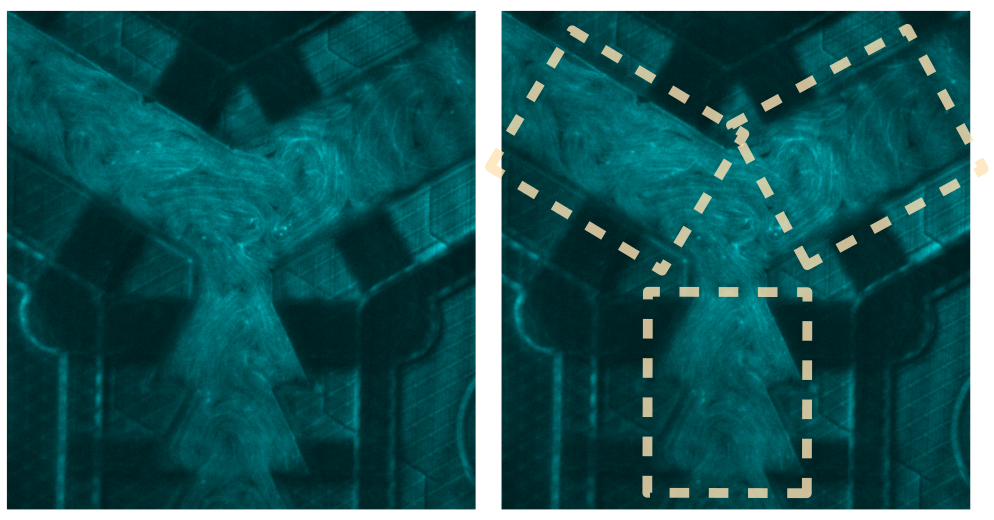

The above image (left) is an example microscopic view under a microscope. The bottom channel is modified with ratchet structures, and is therefore the inlet. The two branches on the top are the test channels. We want to measure the flow rate in the 3 channels separately. It's convenient to crop rectangular regions containing each branch, as shown in the right panel above. And then rotate the region to horizontal or vertical direction, so that the velocity along the channel direction is just the horizontal or vertical component of the measured velocity. 

In the following, let's write the code to crop the images. 

In [5]:
from skimage import io, draw
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import rotate
from matplotlib.patches import Rectangle
from myimagelib.myImageLib import readdata, bestcolor, show_progress, to8bit
import os
from myimagelib.pivLib import PIV, PIV_masked, read_piv, to_matrix, apply_mask, compact_PIV
from IPython.display import clear_output
from myimagelib.corrLib import divide_windows, corrS
from tifffile import imwrite
from nd2reader import ND2Reader
from scipy.io import loadmat
from scipy.ndimage import uniform_filter1d

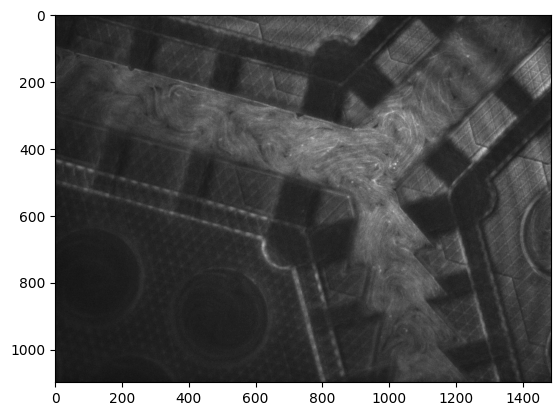

In [3]:
img = io.imread(r"test_files/crop-test.tif")
plt.imshow(img, cmap="gray")

The first step is to rotate the image, so that each channel have their +1 flow direction going up. For each channel, we need to rotate and crop once. Thus, for a 3-channel grid, we need the knowledge of 3 rotation angles and 3 crop region coordinates after respective rotations. We start by mannually provide these numbers. <font color="red">Later on, we will develop more intelligent algorithm that crops the image more automatically.</font>

### 1.1 Rotation

We want to rotate the raw image above to make, e.g. the ratchet channel, to go upward. We measure manually and find this channel is 14$^\circ$ to the left of the vertical axis. Therefore, we rotate the image -14$^\circ$ to get the desired orientation. 

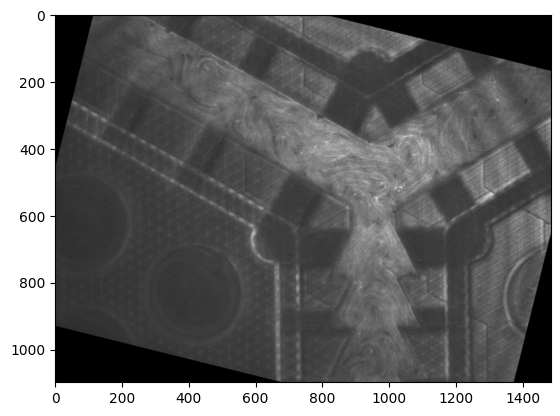

In [4]:
angle = -14
imgr = rotate(img, angle=angle)
plt.imshow(imgr, cmap="gray")

### 1.2 Crop

Next, we want to crop the ratchet channel from the rotated image. A rough measurement suggests that we can use a bounding box (774, 591, 345, 507).

**Note:** the bounding box is represented as (x0, y0, width, height), where x0, y0 are the coordinates of the upper left corner. Width and height are the side lengths of the box in x and y direction, respectively.

Run the block below, we see a red rectangle, indicating the bounding box on the left, and the cropped image on the right.

Text(0.5, 1.0, 'cropped image')

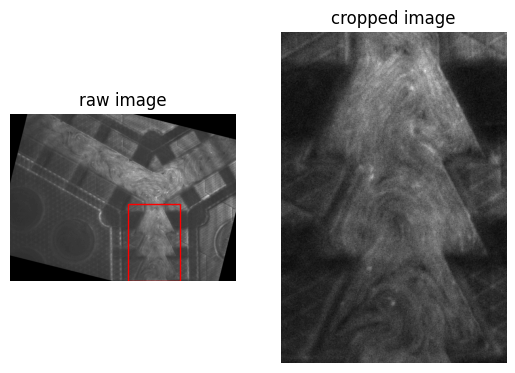

In [5]:
# show rotated image and crop region
x, y, w, h = (774, 591, 345, 507)
imgr = rotate(img, angle=angle)
crop = imgr[y:y+h, x:x+w] # When images are represented as matrix, the first axis is row (corresponding to y) and the second axis is column (corresponding to x)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(imgr, cmap="gray")
rect = Rectangle((x, y), w, h, fill=False, ec="red")
ax[0].add_patch(rect)
ax[0].axis("off")
ax[0].set_title("raw image")
ax[1].imshow(crop, cmap="gray")
ax[1].axis("off")
ax[1].set_title("cropped image")

### 1.3 Manual measurement in ImageJ



ImageJ provide convenient tools for measuring the angles and bounding boxes. From ImageJ, we manually get 3 sets of (rotation angle, crop rectangle), saved in the "crop-data.csv" file as a table (picture below). Here, important information is the angle in odd lines and (BX, BY, Width, Height) in even lines. For example, to get the first crop of the inlet ratchet channel, we first rotate the raw image (angle[1]-90) degrees. Then, crop the resulting image using the rectangle cornered at (X, Y) with width and height (Width, Height) in the second line (2). 

**Note:** when measuring angle, we draw a straight line in the direction of the channel. The direction of this drawing can make a difference to the angle measured. In this application, we always draw the line from the - direction to the + direction, so that in all cropped images, the + direction points upward.

Below is an example of crop data generated from ImageJ manual measurement. 

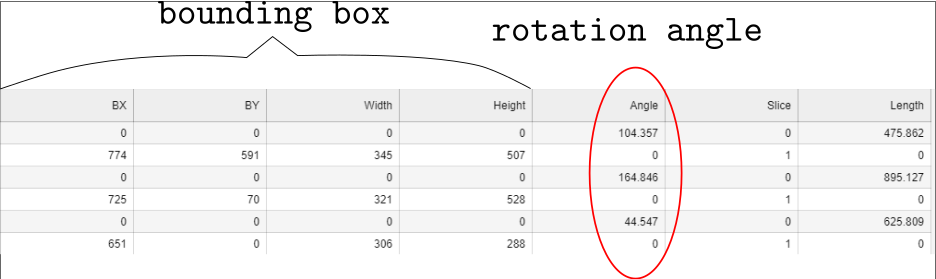

In [6]:
# load crop data from file
crop_data = pd.read_csv(r"test_files/crop-data.csv")
crop_data.head()

BX   BY  Width  Height    Angle  Slice   Length
0  1    0    0      0       0  104.357      0  475.862
1  2  774  591    345     507    0.000      1    0.000
2  3    0    0      0       0  164.846      0  895.127
3  4  725   70    321     528    0.000      1    0.000
4  5    0    0      0       0   44.547      0  625.809

In [7]:
# convert to angle, xy, wh
# use the first two rows of crop data as an example
angle = 90 - crop_data.at[0, "Angle"]
x, y, w, h = crop_data.at[1, "BX"], crop_data.at[1, "BY"], crop_data.at[1, "Width"], crop_data.at[1, "Height"]

### 1.4 Utility functions for cropping

#### 1.4.1 Preview crop

Now, we write a function to preview all the crops. In this specific channel design, we will generate 3 crops from a single image. However, the function here should be compatible with arbitrary numbers of crops. 

In [8]:
def preview_crop(img, crop_data):
    """Preview the channel crops.
    Args:
    img -- raw image
    crop_data -- rotation angle and rectangle descriptor, generate manually from ImageJ
    """
    ncrops = len(crop_data) // 2
    img_in_row = 3
    nrows = ncrops // 3 + 1
    fig = plt.figure(figsize=(6, 2*nrows))
    
    for i in range(0, ncrops):
        angle = 90 - crop_data.at[2*i, "Angle"]
        x, y, w, h = crop_data.at[2*i+1, "BX"], crop_data.at[2*i+1, "BY"], crop_data.at[2*i+1, "Width"], crop_data.at[2*i+1, "Height"]
        imgr = rotate(img, angle=angle)
        crop = imgr[y:y+h, x:x+w]
        ax = fig.add_subplot(nrows, img_in_row, i+1)
        ax.imshow(crop, cmap="gray")

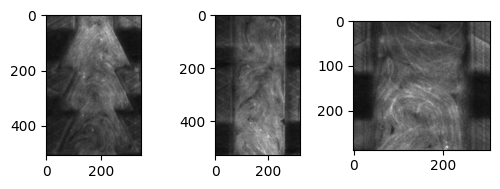

In [9]:
img = io.imread(r"test_files/crop-test.tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
preview_crop(img, crop_data)

## 2 Flow rate analysis

We use [particle image velocimetry](https://en.wikipedia.org/wiki/Particle_image_velocimetry) (PIV) as the primary tool to get velocity fields from images. The patterns of fluorescent filaments are used as tracer particles for motion detection. The velocity fields are then used to compute flow rate.

### 2.1 PIV

#### 2.1.1 Normal PIV on cropped images

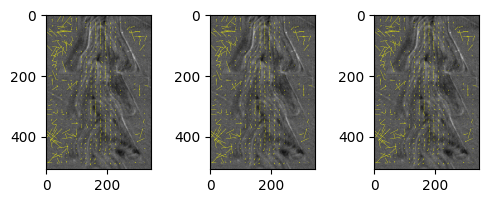

In [11]:
folder = "test_files/PIV"
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6, 2))
for i in range(3):
    I0 = io.imread(os.path.join(folder, "0000.tif"))
    I1 = io.imread(os.path.join(folder, "0001.tif"))
    x, y, u, v = PIV(I0, I1, 32, 16, 1)
    ax[i].imshow(I0, cmap="gray")
    ax[i].quiver(x, y, u, v, color="yellow")

If we directly apply PIV on the cropped images, we will have velocities from both inside the channel and outside the channel. The out-of-channel velocities can be simply filtered by applying a mask, as we shall show in the next section.

#### 2.1.2 Apply mask

The goal is to set all the out-of-channel velocities to `np.nan`, so that they won't be problematic in the downstream analysis. To identify which velocity is out-of-channel, we can use ImageJ to draw a binary mask by hand, which looks like the following:

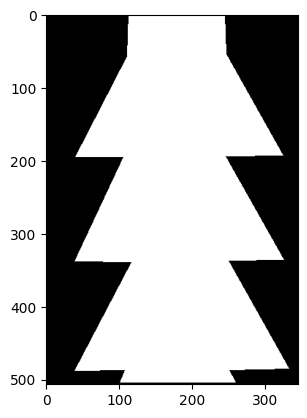

In [11]:
mask = io.imread("test_files/mask/mask.tif")
plt.imshow(mask, cmap="gray")

The mask is actually an image of the same size as the original cropped images. In-channel part is labelled with large values (white), and out-of-channel part is labelled with small values (black). The mask is usually saved as 8-bit images, with all small values 0 and large values 255. When used as mask, however, it is convenient to convert them to boolean arrays:

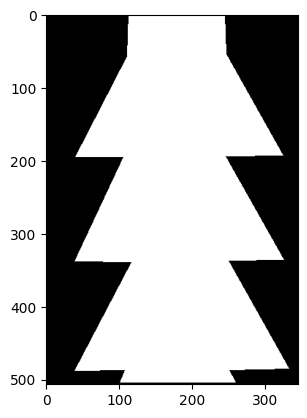

In [14]:
mask = mask > mask.mean()
plt.imshow(mask, cmap="gray")

While the boolean array looks the same as 8-bit, in the form of image, the values are just `True` or `False`:

In [15]:
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Now, we can start to classify the velocities into two categories: in-channel (valid) and out-of-channel (invalid). Each velocity has four properties: x, y, u, v, where x, y are the position and u, v are the magnitude. By checking if x, y fall into the in-channel part or the out-of-channel part, we can classify them. 

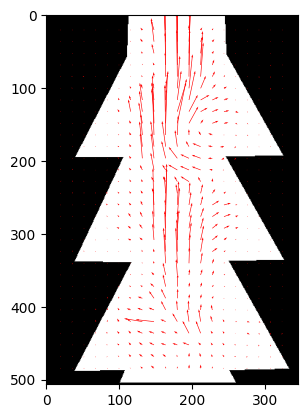

In [17]:
pivData = pd.read_csv("test_files/PIV/0000-0001.csv")
plt.imshow(mask, cmap="gray")
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v, color="red")

In [19]:
ind = mask[pivData.y.astype("int"), pivData.x.astype("int")]
ind

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,

`ind` is a boolean array of the same length as `pivData`. The values correspond to the value on the `mask` at the corresponding position x, y. Therefore, `ind` being `True` means the corresponding velocity is in-channel, and otherwise out-of-channel. The box below sets invalid velocities to `np.nan`.

In [23]:
pivData.loc[~ind, "u"] = np.nan
pivData.loc[~ind, "v"] = np.nan

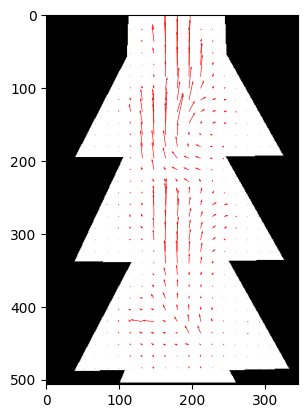

In [24]:
plt.imshow(mask, cmap="gray")
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v, color="red")

Compare the quiver plot above with the original one, we notice immediately that the mask is applied.

#### 2.2.3 Apply mask new strategy

Recently, when reading OpenPIV documents, I realize that there is a better strategy to store masked PIV data: on top of x, y, u, v columns, add a mask column, which labels if PIV data at certain points are valid or not. Although it will take slightly more space to store an additional column, compared to my old way to just replace invalid velocities with `np.nan`, this strategy allows me to recover the original PIV results without running the cross-correlation algorithm again. This is especially useful when we want to test different masks, e.g. different treatments to the boundaries.

In [25]:
pivData = pd.read_csv("test_files/PIV/0000-0001.csv")
mask = io.imread("test_files/mask/mask.tif")
mask = mask > mask.mean()
ind = mask[pivData.y.astype("int"), pivData.x.astype("int")]

Up to this point, we are doing the same thing as the previous section. The only difference is that, instead of setting `np.nan` to invalid velocities, the new strategy keeps all the raw data, but adds a new column "mask" to the original PIV data, with the `True` and `False` array `ind`:

In [27]:
pivData["mask"] = ind

The resulting `pivData` is then a `DataFrame` with 5 columns: x, y, u, v, mask.

In [28]:
pivData

x      y         u         v   mask
0     19.5   20.5  0.000000  0.000000  False
1     35.5   20.5  0.000000  0.020879  False
2     51.5   20.5  0.000000  0.020879  False
3     67.5   20.5 -0.003421  0.000000  False
4     83.5   20.5 -0.050930  0.000000  False
..     ...    ...       ...       ...    ...
595  259.5  484.5 -0.086039  0.000000   True
596  275.5  484.5 -0.086039  0.000000   True
597  291.5  484.5 -0.028640 -0.030356   True
598  307.5  484.5  0.000000 -0.009515   True
599  323.5  484.5  0.000000  0.000000   True

[600 rows x 5 columns]

When plotting the masked PIV data, we first select the data where mask == True.

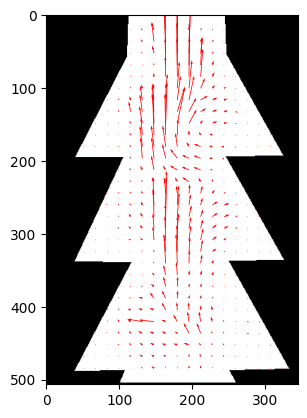

In [29]:
pivDataMasked = pivData.loc[pivData["mask"]==True]
plt.imshow(mask, cmap="gray")
plt.quiver(pivDataMasked.x, pivDataMasked.y, pivDataMasked.u, pivDataMasked.v, color="red")

The same result can be achieve, while the raw data is retained. If in the future we want different boundary treatment to the PIV data, there is no need to redo the PIV, but just to update the mask columns. Since PIV is the most time consuming step in the whole analysis procedure, this new strategy has the potential of saving us a lot of time.


This strategy is implemented in `pivLib.apply_mask()`, see the [official documentation](https://zloverty.github.io/mylib/pivLib/myimagelib.pivLib.apply_mask.html#myimagelib.pivLib.apply_mask) for more details. 

In [13]:
pivData = pd.read_csv("test_files/PIV/0000-0001.csv")
mask = io.imread("test_files/mask/mask.tif")
pivMasked = apply_mask(pivData, mask)

In [14]:
pivMasked.head()

x     y         u         v   mask
0  19.5  20.5  0.000000  0.000000  False
1  35.5  20.5  0.000000  0.020879  False
2  51.5  20.5  0.000000  0.020879  False
3  67.5  20.5 -0.003421  0.000000  False
4  83.5  20.5 -0.050930  0.000000  False

### 2.2 PIV to flow rate

We assume the active nematics system is imcompressible and use volumetric flow rate $Q$ as the flow rate that should be conserved at each point in the channel. 

In each of the cropped channel region, we know from the videos that the primary flow direction is along the channel directions, either being positive or negative. Therefore, we only extract flow in these directions, i.e. the $y$-axis in the cropped images. To get $Q_y$, we integrate velocity $v_y$ along $x$ at an arbitrary $y$ position:
$$
Q_y = \int_{x_1}^{x_2} v_y(x, y)dx
$$
To minimize the noise from the arbitrary choice of $y$ position, we can take an average of $Q_y$ over $y$:
$$
\left< Q_y \right> = \frac{1}{L}\int_0^{L} Q_y dy = \frac{1}{L}\int_0^{L} \int_{x_1}^{x_2} v_y(x, y)dx dy
$$
For a rectangular channel, $x_1$ and $x_2$ are constant for all $y$, so the mean flow rate can be simplified to 
$$
\left< Q_y \right> = W \left< v_y \right>_{x, y}
$$
For ratchet channels (or other non-rectangular channels), where channel width $W$ is not a constant along $y$, we need to compute
$$
\left< Q_y \right> = \frac{1}{L}\int_0^{L} W(y) \left<v_y\right>_x dy
$$

In [ ]:
def compute_flowrate(x, y, u, v):
    """
    Compute volumetric flow rate from masked PIV results.
    x, y, u, v -- PIV data, with invalid velocities as np.nan in u and v.
    """
    mask = ~np.isnan(v)
    x.astype("float")[~mask] = np.nan
    W = np.nanmax(x, axis=1) - np.nanmin(x, axis=1) # channel width along y, px
    v_meanx = np.nanmean(v, axis=1)
    Q = np.nanmean(W*v_meanx)
    return Q

Let's implement the formula now. We start from a masked PIV data `pivMasked`.

In [32]:
pivData = pd.read_csv("test_files/PIV/0000-0001.csv")
mask = io.imread("test_files/mask/mask.tif")
pivMasked = apply_mask(pivData, mask)
pivMasked.head()

x     y         u         v   mask
0  19.5  20.5  0.000000  0.000000  False
1  35.5  20.5  0.000000  0.020879  False
2  51.5  20.5  0.000000  0.020879  False
3  67.5  20.5 -0.003421  0.000000  False
4  83.5  20.5 -0.050930  0.000000  False

First, convert the data to 2D matrices x, y, u, v. Note that to reduce the number of variables needed, we enbed the mask information directly into u and v, by making invalid velocities `np.nan`.

In [33]:
pivMasked.loc[~pivMasked["mask"], "u"] = np.nan
pivMasked.loc[~pivMasked["mask"], "v"] = np.nan
row = len(pivData.y.drop_duplicates())
col = len(pivData.x.drop_duplicates())
x = np.array(pivData.x).reshape((row, col))
y = np.array(pivData.y).reshape((row, col))
u = np.array(pivData.u).reshape((row, col))
v = np.array(pivData.v).reshape((row, col))

Here, `v` is the velocity component along the channel. We want to average it in the direction perpendicular to the channel to get the mean velocity in y direction $\left< v_y \right>_x$.

In [36]:
v_mean = np.nanmean(v, axis=1)
v_mean.shape

(30,)

We can infer the width of the channel at various $y$ by looking at the min and max values of $x$ at each $y$. The idea is shown in the following sketch:

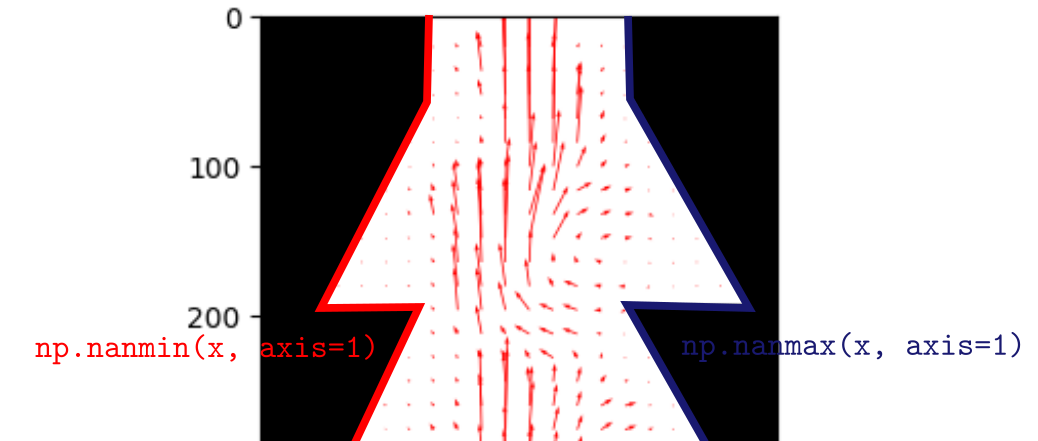

In [37]:
# infer mask from v
mask = ~np.isnan(v)
# apply mask on x
x.astype("float")[~mask] = np.nan
# compute channel width at each y
W = np.nanmax(x, axis=1) - np.nanmin(x, axis=1)
W.shape

(30,)

We can see that the shape of both `v_mean` and `W` are (30,). Indeed, they are corresponding mean velocity and channel width at each $y$. Multiply them gives the flow rate at each $y$ in this frame:

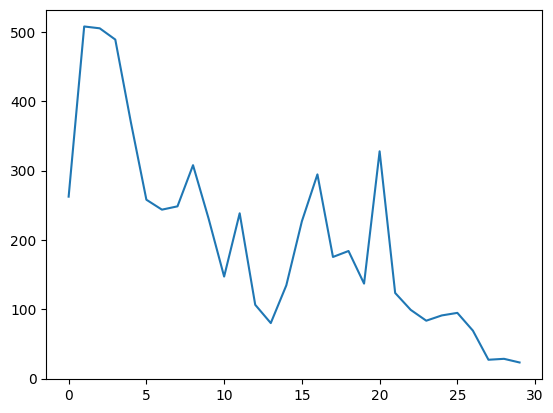

In [38]:
fr = W * v_mean
plt.plot(fr)

In principle, the flow rate at various $y$ should be consistent, due to continuity constraint. However, due to the chaotic nature of the flow and imperfections in images, there are variations in the flow rate. To take advantage of all the data, we use the mean value of flow rate at all the $y$ as the single number flow rate in this channel:

In [39]:
fr.mean()

203.81392196071602

The positive value suggests that the velocity in average is going up in the image. This is consistent with what we see in the quiver plot. In the context of experiment, it is always good to **double check the sign** of the flow rate to see if it has the desired behavior.

## 3 Test preprocess - subtract background (in particular the dark concentric rings)

<font color="red"> The code in this section uses large raw image files for test. It only execute correctly on my local system and will not work on other systems without the files. Therefore, this section is READ ONLY.</font>

We notice that the images from the Gulliver confocal always have outstanding concentric dark rings, likely caused by the confocal spin unit (CSU). In the previous sections, we have analyzed the images without correcting these rings. Here, we compare the results from with/without correction, to see if a correction is necessary. If necessary, we will implement a python version of batch background subtration. 

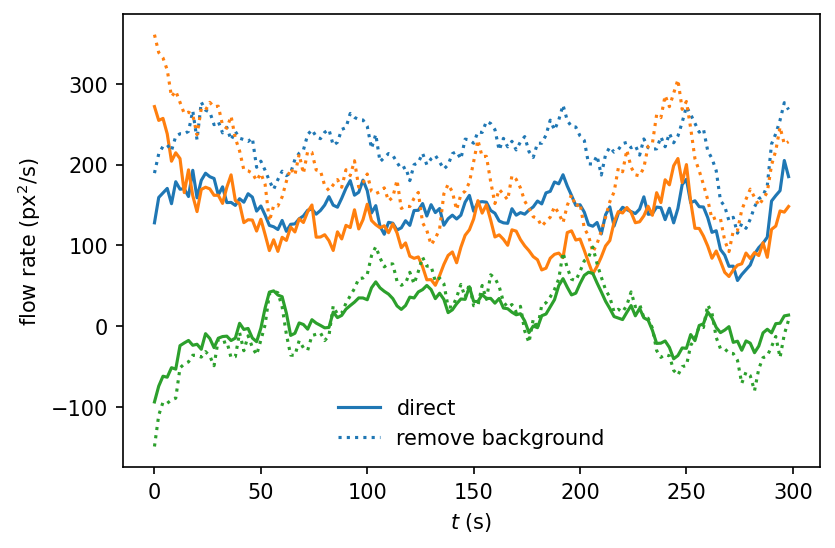

In [30]:
flowrate_folder = r"E:\AN\10172022\channel_flowrate"
flowrate_folder_rb = r"E:\AN\10172022\channel_flowrate_rb"
n = 5
# fig = plt.figure(figsize=(16, 9), dpi=100)
fig, ax = plt.subplots(dpi=150)
data = pd.read_csv(os.path.join(flowrate_folder, "{:02d}.csv".format(n)))
data_rb = pd.read_csv(os.path.join(flowrate_folder_rb, "{:02d}.csv".format(n)))
# ax = fig.add_subplot(5, 3, num+1)
ax.plot(data.t, data["crop-0"], label="direct", color=bestcolor(0))
ax.plot(data.t, data["crop-1"], color=bestcolor(1))
ax.plot(data.t, data["crop-2"], color=bestcolor(2))
ax.plot(data.t, data_rb["crop-0"], label="remove background", color=bestcolor(0), ls=":")
ax.plot(data.t, data_rb["crop-1"], color=bestcolor(1), ls=":")
ax.plot(data.t, data_rb["crop-2"], color=bestcolor(2), ls=":")
ax.set_xlabel("$t$ (s)")
ax.set_ylabel("flow rate (px$^2$/s)")
# ax.plot(data.t, data["crop-0"] - data["crop-1"] - data["crop-2"], color="gray", ls="--", label="$A-B-C$")

ax.legend(frameon=False)

The above comparison suggests that there is noticealbe difference between PIV on images with/without background subtraction. On images where background is subtracted, the measured velocity is generally larger than original images. This is expected because the dark rings in the images are stationary patterns, which make the detected motion slower. In the future, all the PIV should be done on images where background is subtracted. Here, we implement a code to batch process raw images. 

### 3.1 Median z-projection

In [32]:
raw_folder = r"E:\AN\10122022\00\raw"
rb_folder = r"E:\AN\10122022\00\remove-background"
if os.path.exists(rb_folder) == False:
    os.makedirs(rb_folder)
l = readdata(raw_folder, "tif")
imgs = []
for num, i in l.iterrows():
    img = io.imread(i.Dir)
    imgs.append(img)
stack = np.stack(imgs, axis=0) # TXY image stack

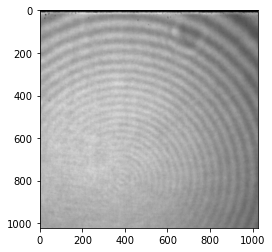

In [33]:
# median projection
med = np.median(stack, axis=0)
plt.imshow(med, cmap="gray")

### 3.2 Divide raw images by the median projection

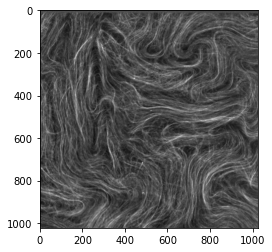

In [34]:
img = stack[0]
plt.imshow(img/med, cmap="gray")

In [52]:
subtract_stack = np.divide(stack, med)
img = subtract_stack[0]
plt.imshow(img, cmap="gray")

MemoryError: Unable to allocate 43.7 GiB for an array with shape (3601, 1098, 1484) and data type float64

Unable to do `np.divide` with the whole stack, because memory is not enough. But it's possible to do it frame-wise.

In [35]:
imgr0 = stack[0] / med
low, high = imgr0.min(), imgr0.max()
for num, img in enumerate(stack):
    imgr = img / med
    img8 = ((imgr - low) / (high - low) * 255).astype(np.uint8)
    io.imsave(os.path.join(rb_folder, "{:05d}.tif".format(num)), img8)

### 3.3 Remove tiffstack background

In [3]:
img_folder = r"A:\SYMMETRIC\14 dec 2022\nd2\crop_channel"
stack = io.imread(os.path.join(img_folder, "00_A.tif"))
med = np.median(stack, axis=0)

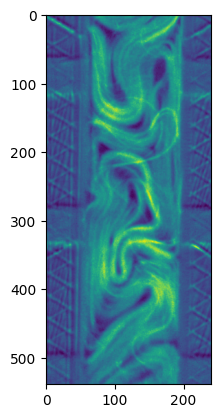

In [7]:
plt.imshow((stack / med)[0])

## 4 Flow configuration probability

We plot the histogram of flow configuration on a $\phi_B$-$\phi_C$ axis. Note that for original flow rate data (with physical units), we can plot histogram for each video, or even different videos of a day. But due to the fact that microtubule activity varies from day to day, mixing flow rate data from multiple days creates chaos. In this case, we can normalize the flow rate data first and then combine in the same histogram plot. The description of normalization is lengthy and does not fit in this notebook, I have since moved it to [a separate notebook](flow-rate-normalization.ipynb).

### 4.1 Scattered histogram

We start by reading an example flow rate data.

In [45]:
folder = r"test_files\flowrate\17 oct 2022"
flowrate = pd.read_csv(os.path.join(folder, "04.csv"))

In [46]:
flowrate.head()

A           B           C    t
0 -598.763450  692.969020 -140.977890  0.0
1 -616.239204  642.865477 -128.967838  1.0
2 -576.399152  647.296450 -143.677066  2.0
3 -525.318805  658.192658 -158.032235  3.0
4 -523.964774  640.820148 -145.782990  4.0

Then, we compute the histogram using `np.histogram2d` and then visualize it using `plt.imshow`. The idea is to show the 2D histogram as an image, using the pixel intensities to indicate probabilities. Below is a minimal code for the computation + visualization.

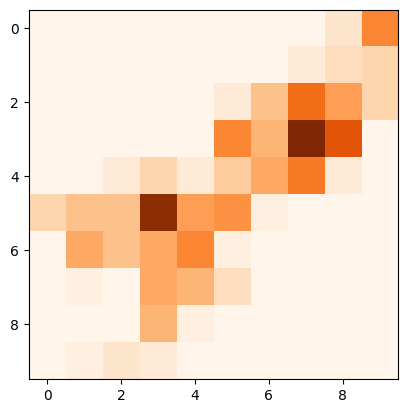

In [57]:
H, xedges, yedges = np.histogram2d(flowrate["B"], flowrate["C"])
plt.imshow(H, cmap="Oranges")

We see the histogram as an image. It is a 10x10 matrix, which is from the default bin number of `np.histogram`. We notice some problems in this visualization:

- the tick labels are not flow rate values, but rather the default pixel index from 0 to the length of the data. This happens because we have not specified the range to show this image on.
- To compare with theory, we want to plot the probability distribution around the origin.
- the number of bins is too few: we want finer histogram and this can be achieved by customizing the bin in `np.histogram2d`.

Let's fix these problems now.


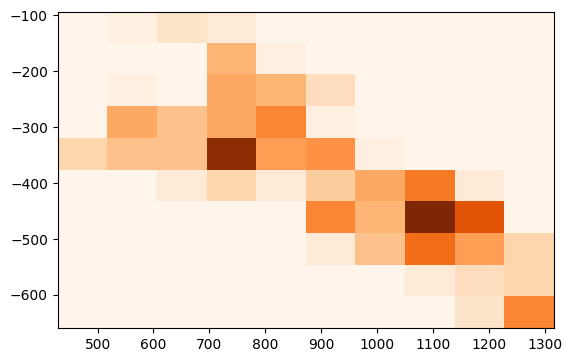

In [80]:
H, xedges, yedges = np.histogram2d(flowrate["B"], flowrate["C"])
plt.imshow(H, cmap="Oranges", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower")

By specifying the `extent` keyword argument, we change the tick labels to flow rate values. We plot the flow rate time series below, and notice that flow B is always positive and flow C is always negative. That discerns that two axes: x - B, y - C.

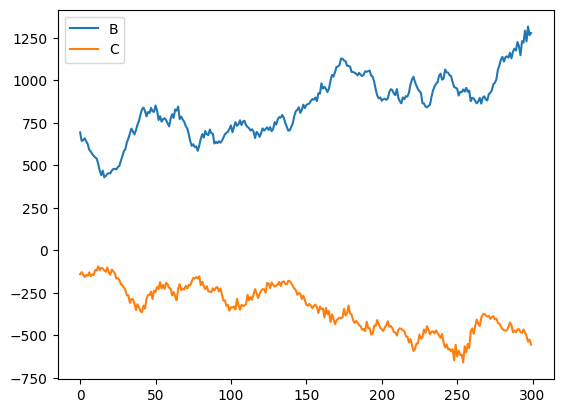

In [60]:
plt.plot(flowrate["B"], label="B")
plt.plot(flowrate["C"], label="C")
plt.legend()

Now, let's set the bins to be centered around the origin.

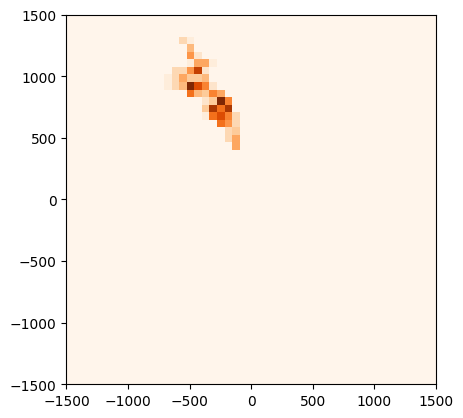

In [82]:
lim = 1500
H, xedges, yedges = np.histogram2d(flowrate["B"], flowrate["C"], bins=np.linspace(-lim, lim))
plt.imshow(H, cmap="Oranges", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower")

<font color="red"> Somehow, the two axis swap after I mannually set `bins`. Originally, the mapping was x-B, y-C, but now it's x-C, y-B, as evidenced in the signs of probable flow rates. This is not yet understood, but let's just accept this and continue for now. </font>

We can also place some guide-of-the-eye's in the plot. For example, the lines where $x=0$ and $y=0$. And also axis labels to indicate the concerned flow rates (A, B, C)

Text(0, 0.5, 'B')

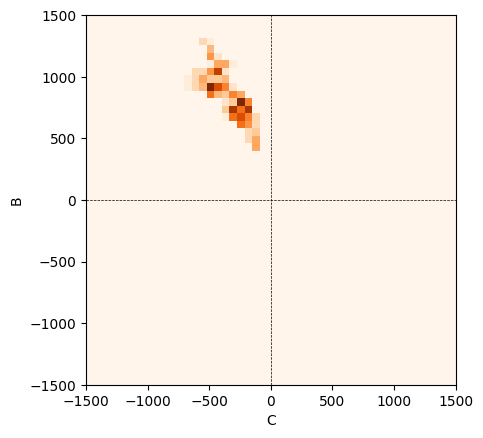

In [85]:
lim = 1500
H, xedges, yedges = np.histogram2d(flowrate["B"], flowrate["C"], bins=np.linspace(-lim, lim))
plt.imshow(H, cmap="Oranges", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin="lower")
plt.plot([0, 0], [-lim, lim], lw=0.5, color="black", ls="--")
plt.plot([-lim, lim], [0, 0], lw=0.5, color="black", ls="--")
plt.xlabel("C")
plt.ylabel("B")

### 4.2 Contour plot

This is just a variation of visualization, while all the information is unchanged from the previous section.

(-1500.0, 1500.0)

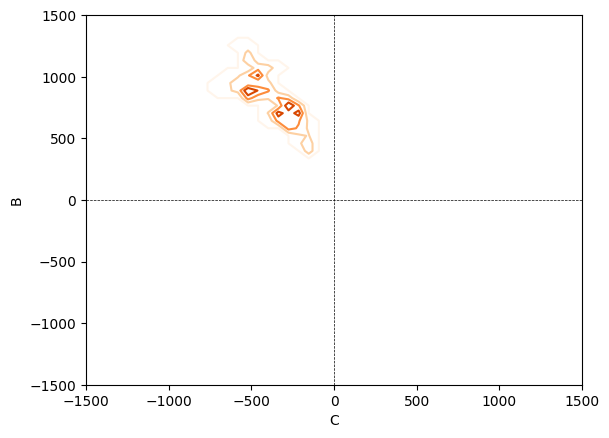

In [90]:
lim = 1500
H, xedges, yedges = np.histogram2d(flowrate["B"], flowrate["C"], bins=np.linspace(-lim, lim))
levels = np.linspace(np.min(H), np.max(H), 5)
plt.contour(xedges[:-1], yedges[:-1], H, levels=levels, cmap="Oranges")
plt.plot([0, 0], [-lim, lim], lw=0.5, color="black", ls="--")
plt.plot([-lim, lim], [0, 0], lw=0.5, color="black", ls="--")
plt.xlabel("C")
plt.ylabel("B")
plt.xlim([-lim, lim])
plt.ylim([-lim, lim])

## 5 Data summary / visualization

We've got a nice organization of the bifurcation data. However, when going into the data folder, the only information we can get is still the DRY numbers representing flow rates in each channel evolving over time. An overview is needed for each day of experiment (or each grid, usually we do one grid a day). The overview should make clear the key information from the dataset. An example is illustrated below:

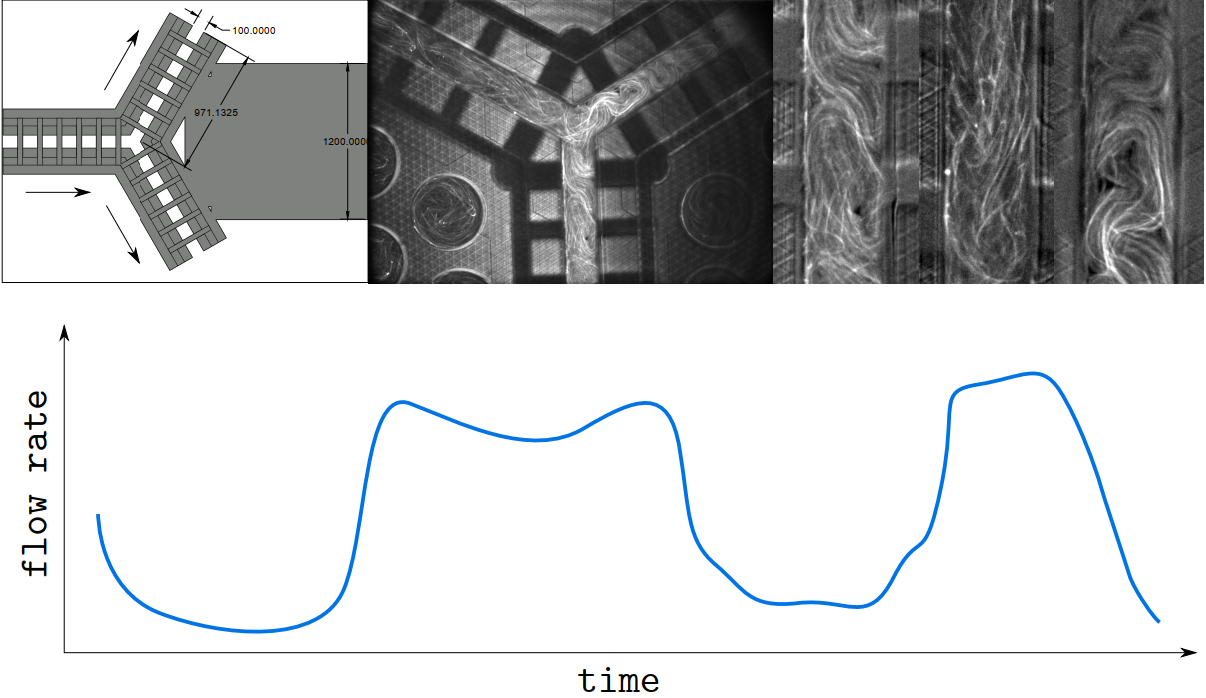

I think the best place to put the overview is the main data folder under which we have many date folders. There we can create PPT slides and make each page a summary of one day's experiment.

### 5.1 Combined flow rate plot

The flow rate data comes from the Flow_rate folder. Different files represent data measured from different videos. Usually, we have multiple videos for each grid, and it is ideal to combine flow rate data for the same grid in one plot. This section implement the combined flow rate time series plot.

(0.0, 16146.0)

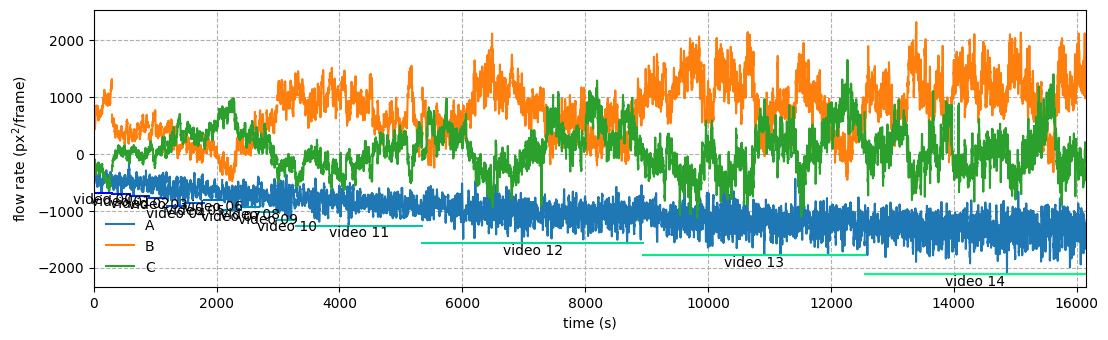

In [91]:
folder = r"test_files\flowrate\17 oct 2022"
files = ["{:02d}.csv".format(i) for i in range(4, 19)]
colors = plt.cm.get_cmap("tab10")
video_colors = plt.cm.get_cmap("winter", len(files))

plt.figure(figsize=(12.8, 3.6), dpi=100)
offset = 0
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    flowrate.dropna(subset="A", inplace=True)
    for i, channel_name in enumerate(flowrate.drop(columns=["t"])):
        if num == 0:
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors(i), label=channel_name)
        else:
            plt.plot(flowrate.t + offset, flowrate[channel_name], color=colors(i))
    # video indicator
    offset0 = offset
    offset += flowrate["t"].max()
    y = flowrate.drop(columns=["t"]).min().min()
    plt.plot([offset0, offset], [y, y], color=video_colors(num))
    plt.annotate("video {:02d}".format(num), ((offset0+offset)/2, y), xycoords="data", 
                horizontalalignment="center", verticalalignment="top")
plt.grid(True, ls="--")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("flow rate (px$^2$/frame)")
plt.xlim([0, offset])


### 5.2 Flow rate histogram

This is the easiest visualization to see if the bifurcation is equally probable or polarized. Add this to the data over view. 

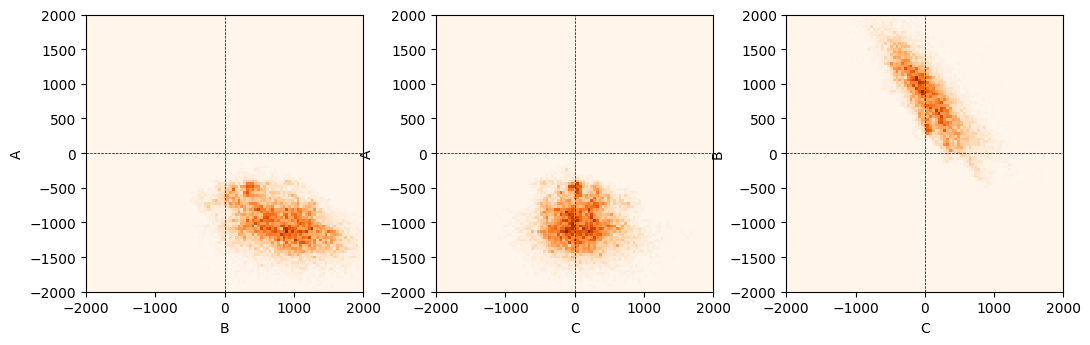

In [94]:
folder = r"test_files\flowrate\17 oct 2022"
files = ["{:02d}.csv".format(i) for i in range(4, 19)]

fig, ax = plt.subplots(ncols=3, figsize=(12.8, 3.6), dpi=100)
fr_list = []
lim = 2000
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    # flowrate["B"] = np.nan
    flowrate.dropna(subset=["A"], inplace=True)
    fr_list.append(flowrate)
combined = pd.concat(fr_list)
for num, i1, i2 in ((0, "A", "B"), (1, "A", "C"), (2, "B", "C")):
    H, xedges, yedges = np.histogram2d(combined[i1], combined[i2], bins=(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100)))
    ax[num].imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax[num].plot([-lim, lim], [0, 0], ls="--", lw=0.5, color="black")
    ax[num].plot([0, 0], [-lim, lim], ls="--", lw=0.5, color="black")
    ax[num].set_xlim([-lim, lim])
    ax[num].set_ylim([-lim, lim])
    ax[num].set_xlabel(i2)
    ax[num].set_ylabel(i1)

### 5.3 Normalized histogram

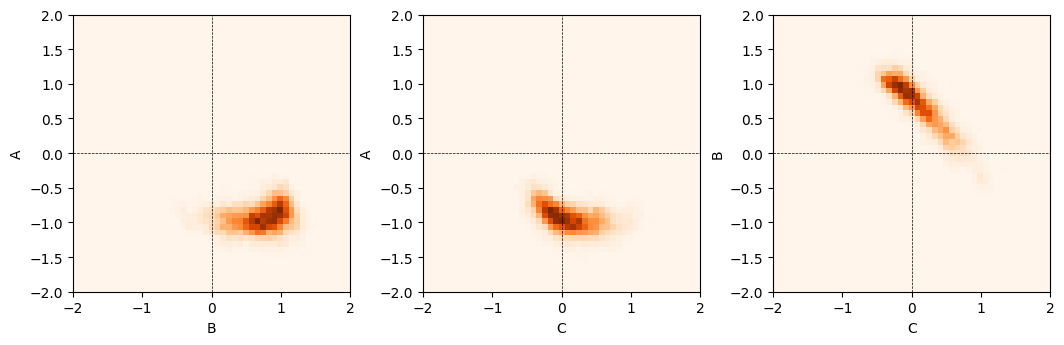

In [95]:
window_size = 50 # frames, 1 frame = 0.5 s
folder = r"test_files\flowrate\17 oct 2022"
files = ["{:02d}.csv".format(i) for i in range(4, 19)]

fig, ax = plt.subplots(ncols=3, figsize=(12.8, 3.6), dpi=100)
fr_list = []
lim = 2
for num, file in enumerate(files):
    flowrate = pd.read_csv(os.path.join(folder, file))
    # flowrate["B"] = np.nan
    flowrate.dropna(subset="A", inplace=True)
    normalizer = uniform_filter1d(flowrate[["A", "B", "C"]].abs().max(axis=1), size=window_size, axis=0)
    flowrate["normalizer"] = normalizer
    # flowrate = flowrate.loc[flowrate.normalizer>50]
    fr_list.append(flowrate)
combined = pd.concat(fr_list)
for num, i1, i2 in ((0, "A", "B"), (1, "A", "C"), (2, "B", "C")):
    H, xedges, yedges = np.histogram2d(combined[i1]/combined["normalizer"], combined[i2]/combined["normalizer"], bins=(np.linspace(-lim, lim, 50), np.linspace(-lim, lim, 50)))
    ax[num].imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
    ax[num].plot([-lim, lim], [0, 0], ls="--", lw=0.5, color="black")
    ax[num].plot([0, 0], [-lim, lim], ls="--", lw=0.5, color="black")
    ax[num].set_xlim([-lim, lim])
    ax[num].set_ylim([-lim, lim])
    ax[num].set_xlabel(i2)
    ax[num].set_ylabel(i1)

### 5.4 Transition dynamics

I told Claire earlier in an email that 

> I think it is interesting too to see the transition process in our experiment, in both the energy landscape and in the detailed structure of active nematics at the bifurcations.

At that moment, I was just impressed by the animation from the Keber 2014 paper. I was not super clear what I really meant. Then Claire's reply clarified the idea a bit:

> Were you thinking to plot the "flow energy" coming from the Woodhouse model, or to use the topological defects in the bifurcation and see how the elastic energy evolves during the transition (or both) ?

BOTH. The idea is to make a connection between the flow network model by Woodhouse, and the active liquid crystal model by Marchetti. The former is a phenomenological model, based on experiments where active fluids transition from turbulent state into coherent flow in channels. The latter is a smaller scale model, associating a free energy with the microscopic structure (local alignment). This is particularly interesting when the flow is undergoing a transition from one stable state to another. According to the flow network model, this transition happens due to a "Brownian noise". However, what is this noise exactly? Do we have methods to control it? This starts to bother me. 

In experiment, we indeed observe transitions in some channel designs. By adding ratchets to the channels, we constrain the flow into fewer possible states. How would we explain the role of the ratchets on the noise? The flow network model does not answer this question, that is why I want to turn to a more microscopic approach -- to study the nematic structure at the joint of 3 channels. I ask a few questions:

- Does the nematic structure suggesting stable / unstable state?
- Is there a link between instantaneous nematic structure and flow rate?

In this section, I make a visualization of flow rate evolution in the following way:

- in a flow rate histogram, plot current state with a red spot, and show histogram up to the current time.
- in a normalized flow rate histogram, plot current state with a red spot, and show histogram up to the current time.

# Appendix

## A. Investigate the weird spikes in ImageJ PIV results

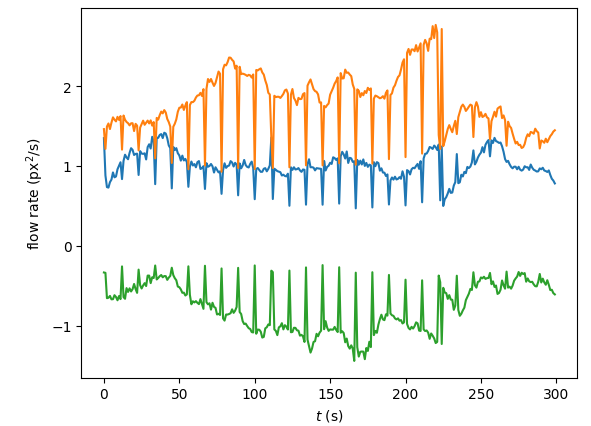

### Where are the spikes?

We can smooth the time series data first, then select the data points that show large deviation. They are the spikes. 

In [232]:
from scipy.signal import medfilt
from myImageLib import bestcolor

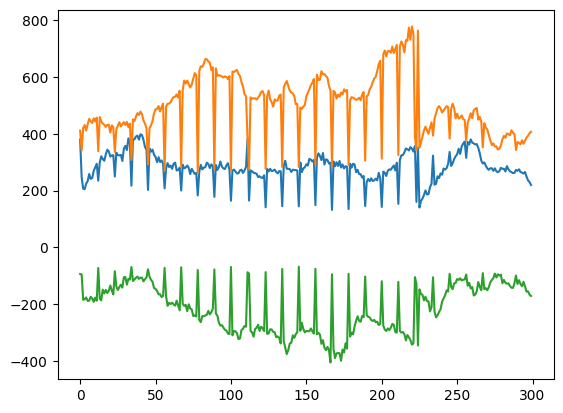

In [231]:
fr_ij = pd.read_csv("test_files/flowrate/ij.csv")
plt.plot(fr_ij["crop-0"])
plt.plot(fr_ij["crop-1"])
plt.plot(fr_ij["crop-2"])

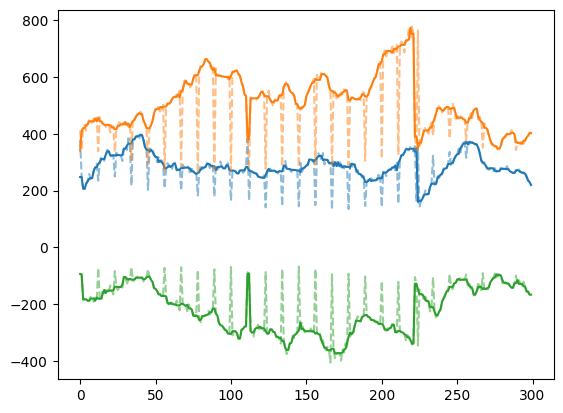

In [236]:
# plot filtered time series
plt.plot(fr_ij["crop-0"], color=bestcolor(0), alpha=0.5, ls="--")
plt.plot(medfilt(fr_ij["crop-0"],3), color=bestcolor(0))
plt.plot(fr_ij["crop-1"], color=bestcolor(1), alpha=0.5, ls="--")
plt.plot(medfilt(fr_ij["crop-1"],3), color=bestcolor(1))
plt.plot(fr_ij["crop-2"], color=bestcolor(2), alpha=0.5, ls="--")
plt.plot(medfilt(fr_ij["crop-2"],3), color=bestcolor(2))

Here, let's set the criterion as "deviation greater than the mean deviation".

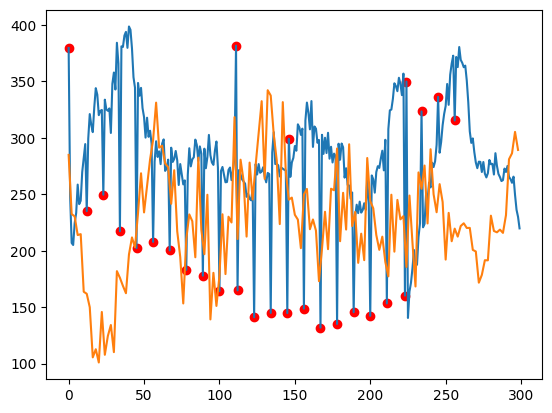

In [243]:
dev = abs(fr_ij["crop-0"] - medfilt(fr_ij["crop-0"],3))
spike_ind = dev > 2 * dev.mean()
plt.plot(fr_ij["crop-0"])
plt.plot(fr_py["t"], fr_py["crop-0"])
plt.scatter(fr_ij[spike_ind].t, fr_ij[spike_ind]["crop-0"], color="red")

### Why I did not see the spikes in the mean velocity time series?

Compute mean velocity again!

In [6]:
ijpiv_folder = r"E:\AN\10172022\channel_crops_rb\04\PIV_crop-0"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"

# mask treatment
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
## py piv
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool_py = mask >= mask.max()
## ij piv
mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))
pivData = pd.read_csv(os.path.join(ijpiv_folder, "_1.txt"), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
mask_bool_ij = mask_shrink.astype("bool")[pivData.y, pivData.x]

In [7]:
l = readdata(ijpiv_folder, "txt")
v_list = []
for num, i in l.iterrows():
    pivData = pd.read_csv(i.Dir, sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    # apply mask
    pivData_masked = pivData.copy()
    pivData_masked.loc[~mask_bool_ij, "u"] = np.nan
    pivData_masked.loc[~mask_bool_ij, "v"] = np.nan
    
    v = -pivData_masked.v.mean()
    v_list.append(v)

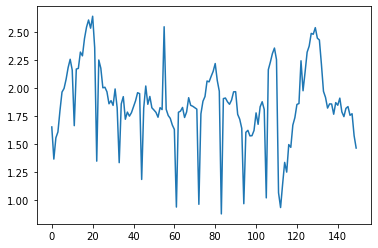

In [12]:
plt.plot(v_list[1::2])

In [17]:
l = readdata(ijpiv_folder, "txt")
c_list = []
for num, i in l.iterrows():
    c_list.append(i.Name)
print(c_list)

['_1', '_10', '_100', '_101', '_102', '_103', '_104', '_105', '_106', '_107', '_108', '_109', '_11', '_110', '_111', '_112', '_113', '_114', '_115', '_116', '_117', '_118', '_119', '_12', '_120', '_121', '_122', '_123', '_124', '_125', '_126', '_127', '_128', '_129', '_13', '_130', '_131', '_132', '_133', '_134', '_135', '_136', '_137', '_138', '_139', '_14', '_140', '_141', '_142', '_143', '_144', '_145', '_146', '_147', '_148', '_149', '_15', '_150', '_151', '_152', '_153', '_154', '_155', '_156', '_157', '_158', '_159', '_16', '_160', '_161', '_162', '_163', '_164', '_165', '_166', '_167', '_168', '_169', '_17', '_170', '_171', '_172', '_173', '_174', '_175', '_176', '_177', '_178', '_179', '_18', '_180', '_181', '_182', '_183', '_184', '_185', '_186', '_187', '_188', '_189', '_19', '_190', '_191', '_192', '_193', '_194', '_195', '_196', '_197', '_198', '_199', '_2', '_20', '_200', '_201', '_202', '_203', '_204', '_205', '_206', '_207', '_208', '_209', '_21', '_210', '_211', '_212',

I understand! The problem is from the data reading order. We want the order to be sorted by number, but in fact the software by default sort by character order. As a result, the default data read order is `['_1', '_10', '_100', '_101', '_102', '_103', '_104', '_105', '_106', '_107', '_108', '_109', '_11', '_110', '_111', '_112', '_113', '_114', '_115', '_116', '_117', '_118', '_119', '_12']`. 100-109 is consecutive, then 11 is an outlier, thus a spike. Then we have 110-119 consecutive, then 12 is an outlier. This explains why we see a spike every 11 points. 

In the previous section, we read the ij PIV data by iterating number $i$ in a range, avoiding sorting data file names. Therefore we don't see spikes there. In the following, we try to read PIV data in the right order. 

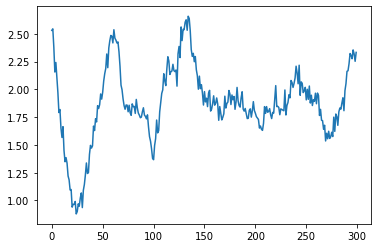

In [20]:
v_list = []
for i in range(1, 301):
    pivData = pd.read_csv(os.path.join(ijpiv_folder, "_{:d}.txt".format(i)), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    # apply mask
    pivData_masked = pivData.copy()
    pivData_masked.loc[~mask_bool_ij, "u"] = np.nan
    pivData_masked.loc[~mask_bool_ij, "v"] = np.nan
    
    v = -pivData_masked.v.mean()
    v_list.append(v)
plt.plot(v_list)

In [252]:
next(os.walk(r"C:\Users\liuzy\Documents\01172022"))[1]

['mask',
 'mean_velocity',
 'preview',
 'velocity_autocorr',
 'velocity_autocorr.old']

## B. Compare Python and ImageJ PIV

We will take 10172022/04 as an example. Eventually, all the videos on 10172022 will be analyzed for comparison. We will be comparing:

- flow field in general: by computing error for each velocity and taking average (for each component)
$$
E_v = \frac{1}{n}\sum_{i=1}^{n} \frac{| v_{\text{python}} - v_{\text{ImageJ}} |}{| v_{\text{python}}  |}
$$
- flow rate: by computing error of low rate for each image 
$$
E_Q =  \frac{| Q_{\text{python}} - Q_{\text{ImageJ}} |}{| Q_{\text{python}}  |}
$$
Then take the mean of the errors from all the images, as a metric of the difference between the two PIV methods. 

### B.1 Create tiff stack

In [74]:
from tifffile import imwrite

In [77]:
image = np.random.rand(*(32, 256, 256))
imwrite("test.tif", image)

In [83]:
folder = r"E:\AN\10172022\channel_crops_rb"
for n in range(5, 19):
    subfolder = os.path.join(folder, "{:02d}".format(n))
    sfL = next(os.walk(subfolder))[1]    
    for sf in sfL:
        img_folder = os.path.join(subfolder, sf)
        print(img_folder)
        l = readdata(img_folder, "tif")
        img_list = []
        for num, i in l.iterrows():
            print(num, end="\r")
            img = io.imread(i.Dir)
            img_list.append(img)
        stack = np.stack(img_list, axis=0)
        imwrite(os.path.join(subfolder, "{}.tif".format(sf)), stack)

E:\AN\10172022\channel_crops_rb\05\crop-0
E:\AN\10172022\channel_crops_rb\05\crop-1
E:\AN\10172022\channel_crops_rb\05\crop-2
E:\AN\10172022\channel_crops_rb\06\crop-0
E:\AN\10172022\channel_crops_rb\06\crop-1
E:\AN\10172022\channel_crops_rb\06\crop-2
E:\AN\10172022\channel_crops_rb\07\crop-0
E:\AN\10172022\channel_crops_rb\07\crop-1
E:\AN\10172022\channel_crops_rb\07\crop-2
E:\AN\10172022\channel_crops_rb\08\crop-0
E:\AN\10172022\channel_crops_rb\08\crop-1
E:\AN\10172022\channel_crops_rb\08\crop-2
E:\AN\10172022\channel_crops_rb\09\crop-0
E:\AN\10172022\channel_crops_rb\09\crop-1
E:\AN\10172022\channel_crops_rb\09\crop-2
E:\AN\10172022\channel_crops_rb\10\crop-0
E:\AN\10172022\channel_crops_rb\10\crop-1
E:\AN\10172022\channel_crops_rb\10\crop-2
E:\AN\10172022\channel_crops_rb\11\crop-0
E:\AN\10172022\channel_crops_rb\11\crop-1
E:\AN\10172022\channel_crops_rb\11\crop-2
E:\AN\10172022\channel_crops_rb\12\crop-0
E:\AN\10172022\channel_crops_rb\12\crop-1
E:\AN\10172022\channel_crops_rb\12

### B.2 Read PIV data from ImageJ 

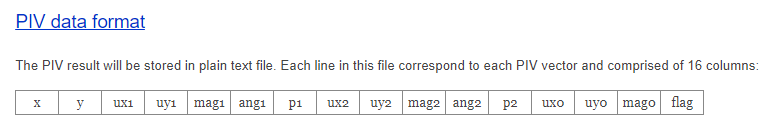

In [3]:
data_folder = r"E:\AN\10172022\channel_crops_rb\04\PIV_crop-0"
l = readdata(data_folder, "txt")
pivData = pd.read_csv(l.loc[0].Dir, sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])

In [4]:
img_folder = r"E:\AN\10172022\channel_crops_rb\04\crop-0"
li = readdata(img_folder, "tif")
img = io.imread(li.loc[0].Dir)

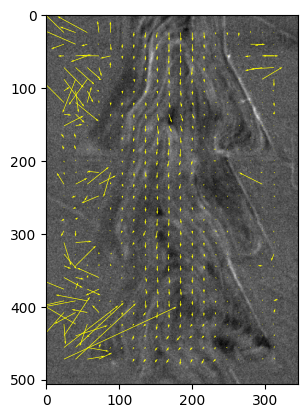

In [5]:
plt.imshow(img, cmap="gray")
plt.quiver(pivData.x, pivData.y, pivData.u, pivData.v, color="yellow")

Apparently, the ImageJ PIV gives opposite velocity in $y$, compared to Python PIV. Need to be careful with this difference.

### B.3 Apply mask

In [65]:
def apply_mask(pivData, mask, erode=1):
    mask = cv2.erode(mask.astype("uint8"), np.ones((erode, erode), dtype="uint8"))
    mask = mask > mask.mean()
    ind = mask[pivData.y.astype("int"), pivData.x.astype("int")]
    p = pivData.copy() # avoid setting values to the original copy
    p.loc[~ind, ["u", "v"]] = np.nan
    return p

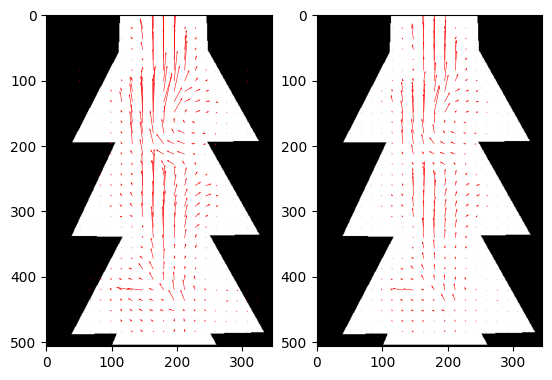

In [69]:
# test
pivData = pd.read_csv("test_files/piv-test.csv")
mask = io.imread("test_files/mask.tif")
mpiv = apply_mask(pivData, mask)

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(mask, cmap="gray")
ax[0].quiver(pivData.x, pivData.y, pivData.u, pivData.v, color="red")
ax[1].imshow(mask, cmap="gray")
ax[1].quiver(mpiv.x, mpiv.y, mpiv.u, mpiv.v, color="red")

In [2]:
piv_folder = r"E:\AN\10172022\channel_piv_rb"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
sfL = ["crop-0", "crop-1", "crop-2"]
for n in range(4, 5):
    for sf in sfL:
        mask = io.imread(os.path.join(mask_folder, "{}.tif".format(sf)))        
        l = readdata(os.path.join(piv_folder, "{:02d}".format(n), sf), "csv")
        save_folder = os.path.join(piv_folder, "{:02d}".format(n), "{}_masked".format(sf))
        if os.path.exists(save_folder) == False:
            os.makedirs(save_folder)
        for num, i in l.iterrows():
            pivData = pd.read_csv(i.Dir)
            mpiv = apply_mask(pivData, mask)
            mpiv.to_csv(os.path.join(save_folder, "{}.csv".format(i.Name)), index=False)

C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\matplotlib\quiver.py:633: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


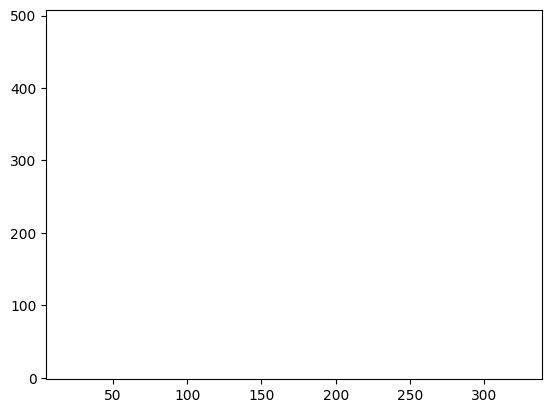

In [6]:
folder = r"E:\AN\10172022\channel_piv_rb\04\crop-0"
n = 0
x, y, u, v = read_piv(os.path.join(folder, "{0:05d}-{1:05d}.csv".format(n, n+1)))
plt.quiver(x, y, u, v)

In [94]:
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool = mask >= mask.max()

My old way of applying masks requires that the PIV windows are put in the same way as my function `divide_windows`. This is not true for the ImageJ PIV. So here we seek a new way to mask PIV results. An intuitive method is to check the PIV xy's one by one, see if they are True or false in the image size mask.

In [135]:
mask_bool = mask_raw.astype("bool")[pivData.y, pivData.x]

In [114]:
pivData_masked = pivData.copy()
pivData_masked.loc[~mask_bool, "u"] = np.nan
pivData_masked.loc[~mask_bool, "v"] = np.nan

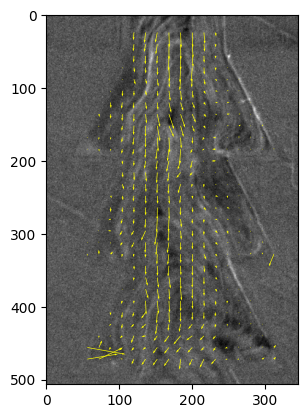

In [116]:
plt.imshow(img, cmap="gray")
plt.quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, pivData_masked.v, color="yellow")

#### Mask near boundary regions -> shrink the mask further

In [142]:
mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))

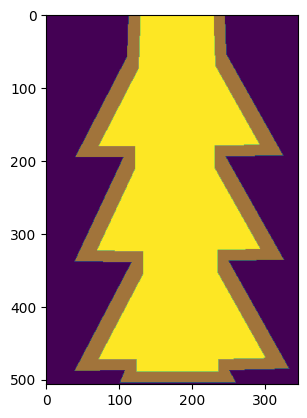

In [143]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(mask_raw)
ax.imshow(mask_shrink, alpha=0.5)

In [144]:
mask_bool = mask_shrink.astype("bool")[pivData.y, pivData.x]

In [145]:
pivData_masked = pivData.copy()
pivData_masked.loc[~mask_bool, "u"] = np.nan
pivData_masked.loc[~mask_bool, "v"] = np.nan

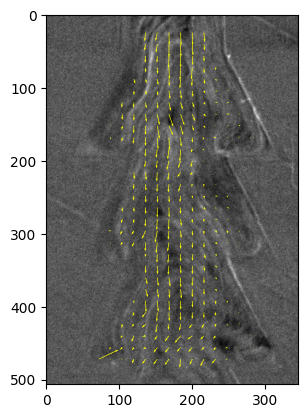

In [146]:
plt.imshow(img, cmap="gray")
plt.quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, pivData_masked.v, color="yellow")

### B.4 Compare with Python results

In [147]:
pypiv_folder = r"E:\AN\10172022\channel_piv_rb\04\crop-0"
x, y, u, v = read_piv(os.path.join(pypiv_folder, "00000-00001.csv"))
# load mask
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool = mask >= mask.max()
# apply mask
u[~mask_bool] = np.nan
v[~mask_bool] = np.nan

(-0.5, 344.5, 506.5, -0.5)

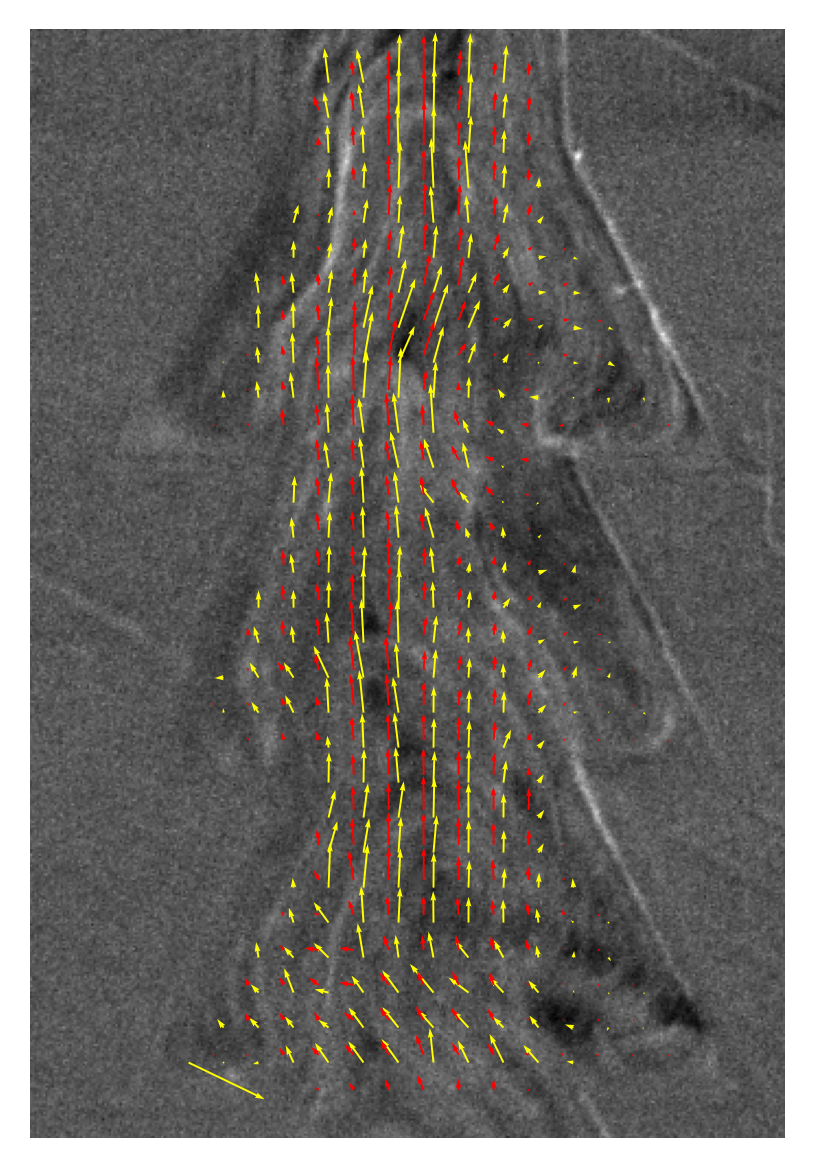

In [149]:
plt.figure(dpi=300)
plt.imshow(img, cmap="gray")
plt.quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, -pivData_masked.v, color="yellow", scale=90)
plt.quiver(x, y, u, v, color="red", scale=90)
plt.axis("off")

#### Mean velocity (vertical)

In [153]:
vi = -pivData_masked.v.mean()
vp = np.nanmean(v)
e = abs(vp - vi) / vp
print(vi, vp, "error={:.2f}".format(e))

2.531077389817271 1.6504453681778235 error=0.53


This is a decent error between the mean velocities. Although the flow field look quite similar.

#### Compare a whole video

In [9]:
img_folder = r"E:\AN\10172022\channel_crops_rb\04\crop-0"
ijpiv_folder = r"E:\AN\10172022\channel_crops_rb\04\PIV_crop-0"
pypiv_folder = r"E:\AN\10172022\channel_piv_rb\04\crop-0"
mask_folder = r"E:\AN\10172022\channel_crops\04\masks"

# mask treatment
mask_raw = io.imread(os.path.join(mask_folder, "crop-0.tif"))
## py piv
X, Y, mask = divide_windows(mask_raw, [32, 32], 16)
mask_bool_py = mask >= mask.max()
## ij piv
mask_shrink = cv2.erode(mask_raw, np.ones((32, 32), dtype="uint8"))
pivData = pd.read_csv(os.path.join(ijpiv_folder, "_1.txt"), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
mask_bool_ij = mask_shrink.astype("bool")[pivData.y, pivData.x]

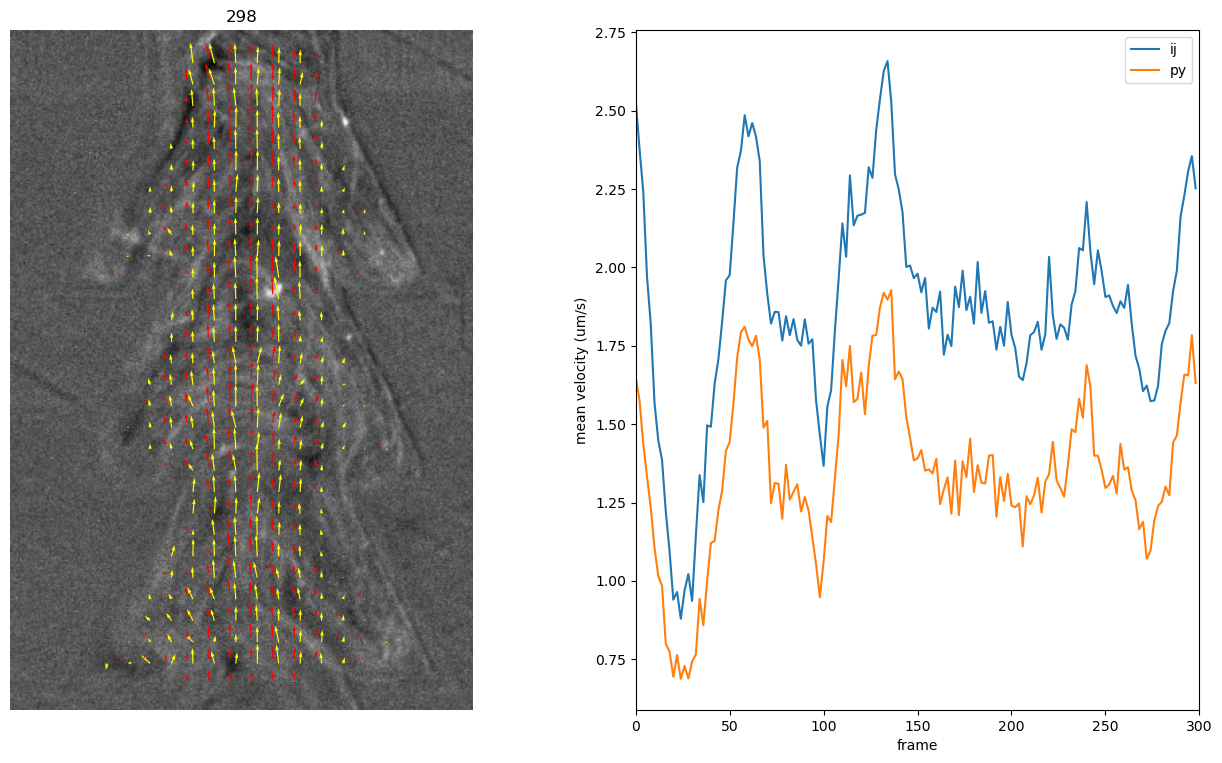

In [10]:
l = readdata(pypiv_folder, "csv")
e_list, vi_list, vp_list = [], [], []
for num, i in l.iterrows():
    # load image
    img = io.imread(os.path.join(img_folder, "{:05d}.tif".format(2*num)))
    # load data
    x, y, u, v = read_piv(i.Dir)
    pivData = pd.read_csv(os.path.join(ijpiv_folder, "_{:d}.txt".format(num*2+1)), sep=" ", usecols=[0,1,2,3], names=["x", "y", "u", "v"])
    # apply mask
    pivData_masked = pivData.copy()
    pivData_masked.loc[~mask_bool_ij, "u"] = np.nan
    pivData_masked.loc[~mask_bool_ij, "v"] = np.nan
    u[~mask_bool_py] = np.nan
    v[~mask_bool_py] = np.nan
    # compute & record error
    vi = -pivData_masked.v.mean()
    vp = np.nanmean(v)
    e = abs(vp - vi) / vp
    vi_list.append(vi)
    vp_list.append(vp)
    e_list.append(e)
    # draw
    fig, ax = plt.subplots(ncols=2, figsize=(16, 9), dpi=100)
    ax[0].set_title(2*num)
    ax[0].imshow(img, cmap="gray")
    ax[0].quiver(pivData_masked.x, pivData_masked.y, pivData_masked.u, -pivData_masked.v, color="yellow", scale=90)
    ax[0].quiver(x, y, u, v, color="red", scale=90)
    ax[0].axis("off")
    # plot mean velocity (flow rate)
    ax[1].plot(range(0, 2*num+1, 2), vi_list, label="ij")
    ax[1].plot(range(0, 2*num+1, 2), vp_list, label="py")
    ax[1].set_ylabel("mean velocity (um/s)")
    ax[1].set_xlabel("frame")
    ax[1].set_xlim([0, 300])
    # ax[1].set_ylim([1, 4])
    ax[1].legend(loc="upper right")
    # savefig
    # fig.savefig("{:05d}.jpg".format(2*num))
    plt.pause(.001)
    plt.close()
    clear_output(wait=True)

#### Compare $\phi_B$-$\phi_C$ histogram

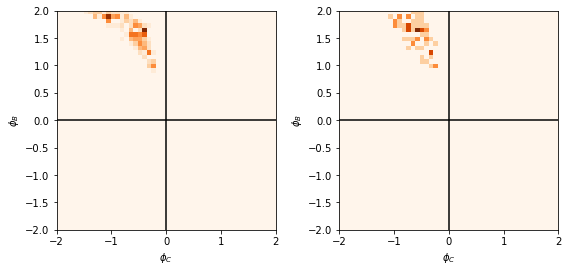

In [25]:
fr_ij = pd.read_csv("test_files/flowrate/ij.csv")
fr_py = pd.read_csv("test_files/flowrate/py.csv")
fr_ij[["crop-1", "crop-2"]] /= fr_ij["crop-0"].mean()
fr_py[["crop-1", "crop-2"]] /= fr_py["crop-0"].mean()

H1, xedges, yedges = np.histogram2d(fr_ij["crop-1"], fr_ij["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
H2, xedges, yedges = np.histogram2d(fr_py["crop-1"], fr_py["crop-2"], bins=[np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].imshow(H1, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax[0].plot([-2, 2], [0, 0], color="black")
ax[0].plot([0, 0], [-2, 2], color="black")
ax[0].set_xlabel("$\phi_C$")
ax[0].set_ylabel("$\phi_B$")

ax[1].imshow(H2, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="Oranges")
ax[1].plot([-2, 2], [0, 0], color="black")
ax[1].plot([0, 0], [-2, 2], color="black")
ax[1].set_xlabel("$\phi_C$")
ax[1].set_ylabel("$\phi_B$")


plt.tight_layout()
# plt.colorbar()

#### Flow rate and normalized flow rate

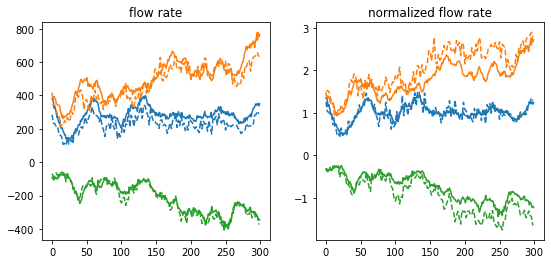

In [29]:
fr_ij = pd.read_csv("test_files/flowrate/ij.csv")
fr_py = pd.read_csv("test_files/flowrate/py.csv")
fr_ij_norm = fr_ij.copy()
fr_py_norm = fr_py.copy()
fr_ij_norm[["crop-0", "crop-1", "crop-2"]] /= fr_ij["crop-0"].mean()
fr_py_norm[["crop-0", "crop-1", "crop-2"]] /= fr_py["crop-0"].mean()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].set_title("flow rate")
ax[0].plot(fr_ij.t, fr_ij["crop-0"], color=bestcolor(0))
ax[0].plot(fr_py.t, fr_py["crop-0"], color=bestcolor(0), ls="--")
ax[0].plot(fr_ij.t, fr_ij["crop-1"], color=bestcolor(1))
ax[0].plot(fr_py.t, fr_py["crop-1"], color=bestcolor(1), ls="--")
ax[0].plot(fr_ij.t, fr_ij["crop-2"], color=bestcolor(2))
ax[0].plot(fr_py.t, fr_py["crop-2"], color=bestcolor(2), ls="--")

ax[1].set_title("normalized flow rate")
ax[1].plot(fr_ij_norm.t, fr_ij_norm["crop-0"], color=bestcolor(0))
ax[1].plot(fr_py_norm.t, fr_py_norm["crop-0"], color=bestcolor(0), ls="--")
ax[1].plot(fr_ij_norm.t, fr_ij_norm["crop-1"], color=bestcolor(1))
ax[1].plot(fr_py_norm.t, fr_py_norm["crop-1"], color=bestcolor(1), ls="--")
ax[1].plot(fr_ij_norm.t, fr_ij_norm["crop-2"], color=bestcolor(2))
ax[1].plot(fr_py_norm.t, fr_py_norm["crop-2"], color=bestcolor(2), ls="--")

### B.5 Call ImageJ PIV function in Python (fail)

Although I personally favor the OpenPIV Python module, which is developed and maintained actively, I understand Claire that she wants the data more consistent. So here I use the ImageJ PIV method to compute velocity field. This will require a package [Py4J](https://www.py4j.org/index.html).

** Failed **

The tutorial example worked, but applying it to the PIV class turns out to be not so straightforward. I briefly document what I have tried, for future reference.

1. I copy-paste the example code "Stack" from py4j tutorial and try to compile using `java Stack.java`, only to realize that I need to install JDK, on top of JRE to compile. JDK is for developer, apparently.

2. Installed JDK, I compile again and run into issues of undefined symbol "Stack". Although I define it already in a file and compile another file which is under the same package. Then I realize that the compile should be on both files in one command, like `java Entry.java Stack.java`, or more simply, `java *.java`.

3. After successfully compiling the code, I run it using `java Entry` (the class name), and it worked correctly. 

4. Using this knowledge on iterative_PIV.java, the compiling part worked as well. But when I try to run the `Entry` class, Java raises undefinedclass error of `ij.plugin.filter.pluginfilter`. I searched about this issue but did not learn much. 

Conclusion: the Java in Python approach is not working. Use ImageJ macro to do the automation.

In [25]:
from py4j.java_gateway import *
port = launch_gateway()
gateway = JavaGateway(
gateway_parameters=GatewayParameters(port=port),
callback_server_parameters=CallbackServerParameters(port=0))
random = gateway.jvm.java.util.Random()

In [28]:
stack.push("First %s" % ('item'))

In [29]:
stack.pop()

'First item'

## C. Try to read broken nd2 files

I notice that some nd2 files are not saved properly, so that the `nd2reader` package is not able to parse the data. The following is the error message, with keywords "no axes were found".

```console
Traceback (most recent call last):
  File "C:\Users\liuzy\Documents\Github\script\crop_channel.py", line 76, in <module>
    with ND2Reader(nd2Dir) as images:
  File "C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\nd2reader\reader.py", line 47, in __init__
    self._setup_axes()
  File "C:\Users\liuzy\Miniconda3\envs\py39\lib\site-packages\nd2reader\reader.py", line 187, in _setup_axes
    raise EmptyFileError("No axes were found for this .nd2 file.")
nd2reader.exceptions.EmptyFileError: No axes were found for this .nd2 file.
```

Let me reproduce the error here.

In [3]:
from nd2reader import ND2Reader
nd2Dir = r"A:\ASYMMETRIC\01 mar 2023\nd2\06.nd2"
with ND2Reader(nd2Dir) as images:
    images[0]

EmptyFileError: No axes were found for this .nd2 file.

Howeve, for some broken nd2 files, the problem appears to be very trivial, as ImageJ bioformats plugin has no problem opening the file and accessing all the frames. Therefore, I suspect that there is a workaround that allow me to open some "broken" nd2 files in Python (with bioformats packages). Here, I test this possibility. Refer to an [issue](https://github.com/Open-Science-Tools/nd2reader/issues/23) of nd2reader.

In [3]:
from pims import ND2_Reader
nd2Dir = r"A:\SYMMETRIC\15 dec 2022\nd2\02.nd2"
frames = ND2_Reader(nd2Dir)
frames[82]

AttributeError: partially initialized module 'pims' has no attribute 'pyav_reader' (most likely due to a circular import)

Apparently, the pims package has more issues and cannot be used even to uncorrupted nd2 files. 

Therefore, I convert the corrupted nd2 file to tiffstack first, and implement a crop_channel for tiffstack here to deal with corrupted nd2 files. 

### C.1 `crop_channel` for tiffstack

<font color="red"> This takes long time and consumes big memory, use with caution! </font>

In [10]:
stackDir = r"A:\ASYMMETRIC\01 mar 2023\nd2\06.tif"

crop_data = pd.read_csv(r"A:\ASYMMETRIC\01 mar 2023\crop_data1.csv")

crop_folder = os.path.join(os.path.split(stackDir)[0], "crop_channel")
if os.path.exists(crop_folder) == False:
    os.makedirs(crop_folder)

# create a dist that holds the cropped images in all regions
crops = {}
for j in range(0, len(crop_data)//2):
     crops[j] = []

# crop nd2
images = io.imread(stackDir)
nImages = len(images)
for num, image in enumerate(images):
    show_progress((num+1)/nImages, str(num))
    for j in range(0, len(crop_data)//2): # loop over all possible croppings
        # convert to angle, xy, wh
        angle = 90 - crop_data.at[2*j, "Angle"]
        x, y, w, h = crop_data.at[2*j+1, "BX"], crop_data.at[2*j+1, "BY"], crop_data.at[2*j+1, "Width"], crop_data.at[2*j+1, "Height"]
        imgr = rotate(image, angle=angle) # rotate
        crop = imgr[y:y+h, x:x+w] # crop
        crops[j].append(crop)

In [11]:
# remove background and save
for j in crops:
    crops[j] = np.stack(crops[j])
    imwrite(os.path.join(crop_folder,  "{0}_{1}.tif".format(os.path.split(stackDir)[1].split(".")[0], chr(65+j))), to8bit(crops[j] / np.median(crops[j], axis=0)))

## D. Quick check PIV

In [23]:
cpiv_dict = loadmat(r"A:\SYMMETRIC\19 jan 2023\PIV\00_C.mat")
cpiv = compact_PIV(cpiv_dict)
img = io.imread(r"A:\SYMMETRIC\19 jan 2023\tif\00_C.tif")
t, h, w = img.shape
for i in range(500):
    x, y, u, v = cpiv.get_frame(i)
    fig = plt.figure(figsize=(w/200, h/200), dpi=200)
    ax = fig.add_axes([0,0,1,1])
    ax.imshow(img[i], cmap="gray")
    ax.quiver(x, y, u, -v, color="yellow", width=.007)
    ax.axis("off")
    fig.savefig(r"C:\Users\liuzy\Downloads\piv\{:05d}.jpg".format(i))
    plt.close()
    # break

## E. Investigate the effect of the dark bands from the bridges

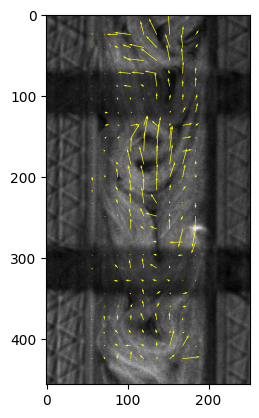

In [39]:
cpiv_dict = loadmat(r"A:\SYMMETRIC\15 dec 2022\PIV\00_A.mat")
cpiv = compact_PIV(cpiv_dict)
x, y, u, v = cpiv.get_frame(0)
img = io.imread(r"A:\SYMMETRIC\15 dec 2022\tif\00_A.tif")
plt.imshow(img[0], cmap="gray")
plt.quiver(x, y, u, v, color="yellow")

In [5]:
def compute_flowrate(x, y, u, v):
    """
    Compute volumetric flow rate from masked PIV results.
    x, y, u, v -- PIV data.
    """
    mask = ~np.isnan(v)
    x.astype("float")[~mask] = np.nan
    W = np.nanmax(x, axis=1) - np.nanmin(x, axis=1) # channel width along y, px
    v_meanx = np.nanmean(v, axis=1)
    Q = np.nanmean(W*v_meanx)
    return Q

Text(0, 0.5, '$\\overline{V_y}$')

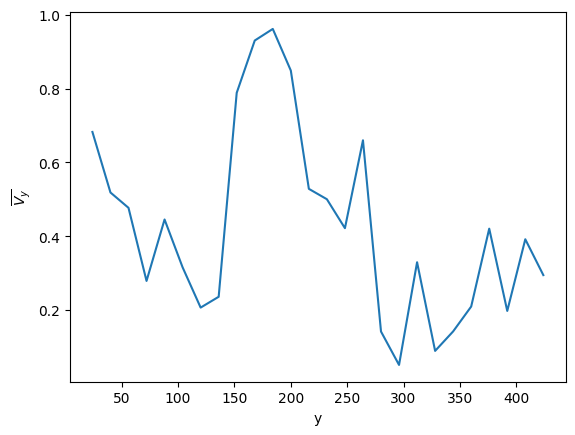

In [78]:
plt.plot(y[:, 0], np.nanmean(abs(v), axis=1))
plt.xlabel("y")
plt.ylabel("$\overline{V_y}$")

In [21]:
cpiv_dict = loadmat(r"A:\SYMMETRIC\15 dec 2022\PIV\00_A.mat")
cpiv = compact_PIV(cpiv_dict)
Q_list = []
Q_crop_list = []
for label in cpiv.get_labels():
    x, y, u, v = cpiv.get_frame(label, by="label")
    Q = compute_flowrate(x, y, u, v)
    Q_list.append(Q)    
    v[(y<120)|(y>280)] = np.nan
    Q = compute_flowrate(x, y, u, v)
    Q_crop_list.append(Q)    

C:\Users\liuzy\AppData\Local\Temp\ipykernel_26172\1819215642.py:9: RuntimeWarning: Mean of empty slice
  v_meanx = np.nanmean(v, axis=1)


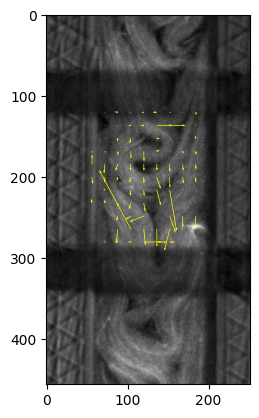

In [22]:
plt.imshow(img[1], cmap="gray")
plt.quiver(x, y, u, v, color="yellow")

Text(0, 0.5, 'flow rate (px$^2$/s)')

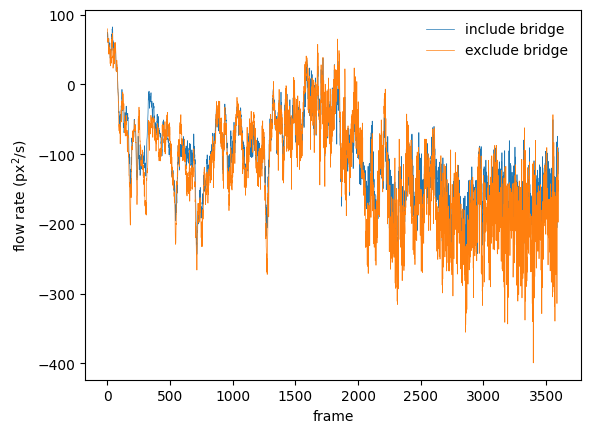

In [26]:
plt.plot(Q_list, lw=0.5, label="include bridge")
plt.plot(Q_crop_list, lw=0.5, label="exclude bridge")
plt.legend(frameon=False)
plt.xlabel("frame")
plt.ylabel("flow rate (px$^2$/s)")

## F. Update mask

In [40]:
piv_folder = r"A:\SYMMETRIC\17 jan 2023\PIV"
mask_folder = r"A:\SYMMETRIC\17 jan 2023\mask"

l = readdata(piv_folder, "mat")
for num, i in l.iterrows():
    name = i.Name.split("_")[1]
    mask_img = io.imread(os.path.join(mask_folder, "{}.tif".format(name)))
    cpiv_dict = loadmat(i.Dir)
    cpiv = compact_PIV(cpiv_dict)
    cpiv.update_mask(mask_img)
    cpiv.to_mat(i.Dir)

In [29]:
-53.569-90

-143.56900000000002

## G. An error in `pivLib.to_matrix`

```
Traceback (most recent call last):
  File "C:\Users\liuzy\Documents\Github\script\wrap_piv.py", line 42, in <module>
    cpiv = compact_PIV(l)
  File "C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\pivLib.py", line 430, in __init__
    self.data = self._from_filelist(data)
  File "C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\pivLib.py", line 470, in _from_filelist
    x, y, u, v = to_matrix(pivData)
  File "C:\Users\liuzy\Documents\Github\mylib\src\myimagelib\pivLib.py", line 64, in to_matrix
    X = np.array(pivData.x).reshape((row, col))
ValueError: cannot reshape array of size 309 into shape (24,13)
```

Reproduce the error.

In [14]:
from myimagelib.myImageLib import readdata
import pandas as pd
from myimagelib.pivLib import to_matrix
import numpy as np

In [2]:
folder = r"C:\Users\liuzy\Documents\00_A"
l = readdata(folder, "csv")

In [7]:
for i in range(1000):
    print(i)
    pivData = pd.read_csv(l.at[i, "Dir"])
    x, y, u, v = to_matrix(pivData)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


ValueError: cannot reshape array of size 309 into shape (24,13)

In [9]:
l.at[i, "Dir"]

'C:\\Users\\liuzy\\Documents\\00_A\\00015.csv'

The issue happens only to the 15th file, i.e. 00015.csv. Read it to see what happens.

In [11]:
errdata = pd.read_csv(l.at[14, "Dir"])
normdata = pd.read_csv(l.at[0, "Dir"])
print("errdata length: {0:d}\nnormdata length: {1:d}".format(len(errdata), len(normdata)))

errdata length: 309
normdata length: 403


An easy fix is to stuff the missing rows with NaN. They will not affect the calculation, but let the to_matrix function go through.

In [35]:
errdata

x      y         u         v   mask
0     24.0   24.0 -0.020340  0.005249  False
1     40.0   24.0  0.033517  0.082610  False
2     56.0   24.0  0.030240 -0.199985  False
3     72.0   24.0 -0.006605 -1.504580   True
4     88.0   24.0  0.053553 -1.192539   True
..     ...    ...       ...       ...    ...
304  104.0  392.0  0.529195 -0.080253   True
305  120.0  392.0  0.122925 -0.108699   True
306  136.0  392.0  0.183587  0.209904   True
307  152.0  392.0  0.080162  0.210824   True
308  168.0  392.0  0.099652  0.157123   True

[309 rows x 5 columns]

In [22]:
null = errdata[:403-309] * np.nan

In [36]:
newdata = pd.concat([errdata, null]).reset_index(drop=True)

Set x, y.

In [41]:
newdata["x"] = normdata["x"]
newdata["y"] = normdata["y"]


In [43]:
newdata.to_csv(os.path.join(folder, "00015.csv"), index=False)

In [42]:
to_matrix(newdata)

(array([[ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  72,  88, 104, 120, 136, 152, 168, 184, 200, 216],
        [ 24,  40,  56,  

## H. Revise the flow rate data

The current data set has some defects: (i) the positive directions are not consistent, (ii) in some experiment we have one channel out of focus, thus prevent PIV measurement. In this section, we fix these issues in old data, so we can treat them uniformly.


### H.1 Positive directions

There is an important change of how the flow rate data is presented. Before Feb 07, 2023, all the flow positive direction in bifurcation project are defined as:

    Channel A: inwards
    Channel B, C: outwards

This is due to the fact that the first experiment I did was with a grid with one ratchet channel going inward, and two straight channels going outward. The ratchet channel was A and by defining positive directions as the above, we guarantee that most flow rates are positive, so the flow rate curves are closer to each other for easier visual inspection. 

Recently, however, we shift our focus to full symmetric channels, where this positive definition causes unnecessary complication. Therefore, on Feb 07, I decided to change this, to always fix positive direction to "outwards", for all the channels. This is a more unambiguous definition, so it's supposedly to be better. 

    Channel A, B, C: outwards

In the following data, flow rate A needs to be inverted: ["17 oct 2022", "31 oct 2022", "04 nov 2022", "14 dec 2022", "15 dec 2022", "17 jan 2023", "19 jan 2023", "31 jan 2023", "01 feb 2023"]. 

NOTE: only Flow_rate data are modified, while the PIV data remains unchanged.

In [24]:
dates = ["17 oct 2022", "31 oct 2022", "04 nov 2022", "14 dec 2022", "15 dec 2022", "17 jan 2023", "19 jan 2023", "31 jan 2023", "01 feb 2023"]
for date in dates:
    folder = os.path.join(r"A:\SYMMETRIC", date, "Flow_rate")
    l = readdata(folder, "csv")
    for num, i in l.iterrows():
        flowrate = pd.read_csv(i.Dir)
        flowrate["A"] *= -1
        flowrate.to_csv(i.Dir, index=False)

### H.2 Missing channels

In some images, one of the three channels is out of focus, resulting in a missing column in flow rate data. Many experiments have shown that the incompressibility condition is met most of the time, so we use this assumption to "recover" the missing data. The following data will be modified: ["05_july_2022", "17 jan 2023"].

In [28]:
date = "10 feb 2023"
folder = os.path.join(r"A:\ASYMMETRIC", date, "Flow_rate")
l = readdata(folder, "csv")
for num, i in l.iterrows():
    flowrate = pd.read_csv(i.Dir)
    flowrate["A"] = - flowrate["B"] - flowrate["C"]
    flowrate[["A", "B", "C", "t"]].to_csv(i.Dir, index=False)

## J. 0-image after cropping

Recently, I saw several times that the cropped images generated by `crop_channel.py` are completely black, filled with 0's. This is particularly true for channel A's with ratchets. So far, this has been observed for the data of 10 feb 2023 and 24 feb 2023. Here, we investigate the cause of this issue. A snapshot of the crop_channel folder is shown below: while channel A's are black, they other two channels look normal.

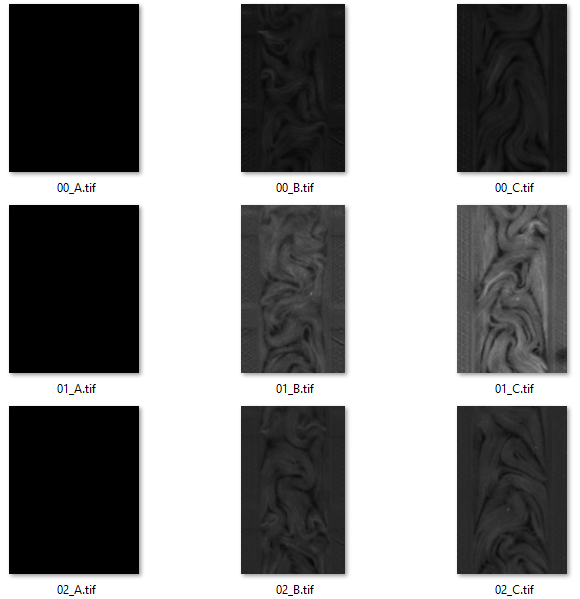

In the commandline, I find more clue: every time when the code tries to perform background subtraction on channel A, it says "invalid value encountered in true_divide", see the snapshot below. 

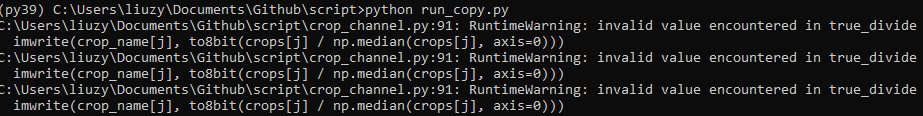

In principle, the value to be divided is the median of an image stack, which is not supposed to be 0. But, what could this "invalid value" be? Let's use the video `24 feb 2023/00.nd2` as an example to find out. 

First, let's read `00.nd2` and save each cropped frame of channel A in a list `crops`. 

In [11]:
nd2Dir = r"A:\ASYMMETRIC\24 feb 2023\nd2\00.nd2"
crop_data = pd.read_csv(r"A:\ASYMMETRIC\24 feb 2023\crop_data1.csv")
angle = 90 - crop_data.at[0, "Angle"]
x, y, w, h = crop_data.at[1, "BX"], crop_data.at[1, "BY"], crop_data.at[1, "Width"], crop_data.at[1, "Height"]
crops = []
with ND2Reader (nd2Dir) as images:
    for num, image in enumerate(images):
        imgr = rotate(image, angle=angle) # rotate
        crop = imgr[y:y+h, x:x+w] # crop
        crops.append(crop)

Then, convert `crops` to a 3D numpy array.

In [13]:
stack = np.stack(crops)

The first dimension of the 3D array is time (frame).

In [15]:
stack.shape

(3600, 460, 354)

The "invalid values" are from the median of this 3D stack. So let's take a median to see what it looks like.

In [16]:
med = np.median(stack, axis=0)

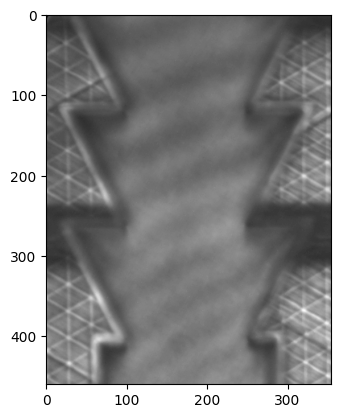

In [18]:
plt.imshow(med, cmap="gray")

It looks totally normal!

In [23]:
med

array([[  0.,   0.,   0., ..., 216., 217., 218.],
       [  0.,   0.,   0., ..., 216., 217., 216.],
       [  0.,   0., 136., ..., 210., 211., 207.],
       ...,
       [567., 558., 539., ..., 633., 592., 564.],
       [581., 573., 539., ..., 634., 615., 590.],
       [586., 590., 542., ..., 618., 612., 609.]])

For record, we check the data types of `stack` and `med`.

In [22]:
stack.dtype

dtype('uint16')

In [20]:
med.dtype

dtype('float64')

Now, divide `stack` with `med`.

In [25]:
sub = stack / med

C:\Users\liuzy\AppData\Local\Temp\ipykernel_16988\1220213339.py:1: RuntimeWarning: invalid value encountered in true_divide
  sub = stack / med


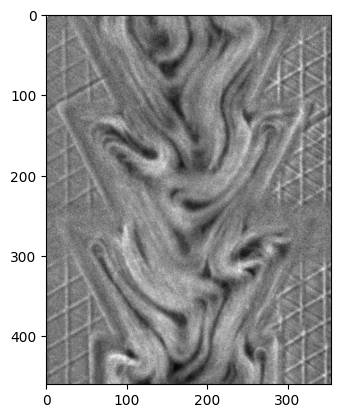

In [26]:
plt.imshow(sub[0], cmap="gray")

If the image is in "float64" type, it look completely fine. What makes it 0 is the next step: `to8bit`:

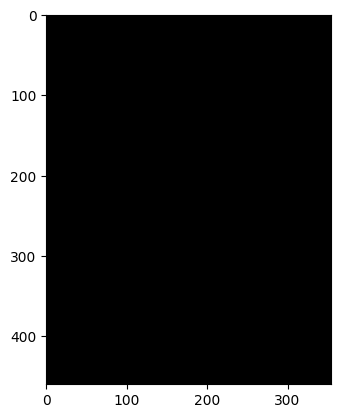

In [32]:
plt.imshow(to8bit(sub[0]), cmap="gray")

I wrote `to8bit` several year ago, just to maximize the contrast of a non-8bit image and then convert to 8-bit. Now, it turns out to be a problem because it does not handle NaN values well. A more robust converting scheme is desired. Here are a few options I can think of right now:

- `numpy.array.astype`
- `skimage.util.img_as_ubyte`
- improve `to8bit` by not considering NaN in rescaling

Let's try them.

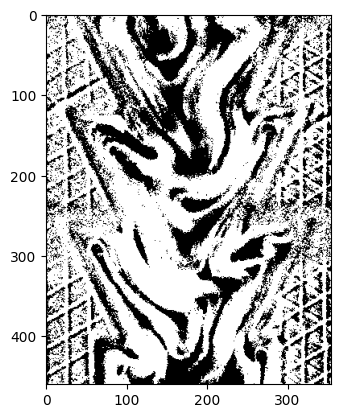

In [31]:
plt.imshow(sub[0].astype("uint8"), cmap="gray")

`numpy.array.astype` does not work.

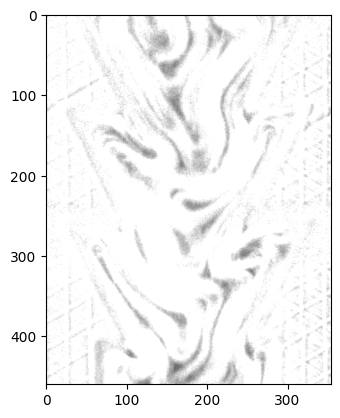

In [33]:
from skimage.util import img_as_ubyte

plt.imshow(img_as_ubyte(sub[0]), cmap="gray")

This is also not great. Let's rewrite `to8bit`.

In [36]:
def to8bit(img):
    """
    Enhance contrast and convert to 8-bit.

    :param img: mono image of any dtype
    :type img: 2d array
    :return: 8-bit image
    :rtype: uint8 2d array
    """
    # if img16.dtype != 'uint16':
        # raise ValueError('16-bit grayscale image is expected')
    maxx = np.nanmax(img)
    minn = np.nanmin(img)
    img8 = (img - minn) / (maxx - minn) * 255
    return img8.astype('uint8')

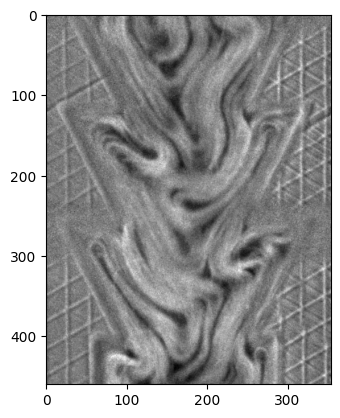

In [38]:
plt.imshow(to8bit(sub[0]), cmap="gray")

Just by handling the NaN, `to8bit` start to work again! So this is the current solution to the 0-image issue. 

## K. Convert the unit of flow rate data to um^2/s

Currently, the data generated by Claire and I use different units for flow rate. Mine is in px^2/frame, and hers is in um^2/s. This was not a problem when computing the histogram, because of the normalization procedure. However, when taking the flow rate into consideration (e.g. does higher flow rate lead to more frequent changes in flow configurations?), we need consistent unit. 

In this section, I want to convert the units of my data to um^2/s. A hard problem here is how to label the converted data, so that I know I have done the conversion already. Our flow rate data now is in a minimal format: .csv file with 4 columns (A, B, C, t), and no metadata exists. 

My first attempt will be this: I first save a copy of the px^2/frame data, and rename the folder from "Flow_rate" to "Flow_rate_pxf", then convert the data in the "Flow_rate" folders. Let's implement this.

In [98]:
from shutil import copy
help(copy)

Help on function copy in module shutil:

copy(src, dst, *, follow_symlinks=True)
    Copy data and mode bits ("cp src dst"). Return the file's destination.
    
    The destination may be a directory.
    
    If follow_symlinks is false, symlinks won't be followed. This
    resembles GNU's "cp -P src dst".
    
    If source and destination are the same file, a SameFileError will be
    raised.



In [101]:
folder = r"A:\ASYMMETRIC"
sfL = next(os.walk(folder))[1]
for sf in sfL:
    if "_" not in sf: # discern claire's data from mine 
        src_folder = os.path.join(folder, sf, "Flow_rate")
        if os.path.exists(src_folder):
            dst_folder = os.path.join(folder, sf, "Flow_rate_pxf")
            if os.path.exists(dst_folder) == False:
                os.makedirs(dst_folder)
            l = readdata(src_folder, "csv")
            for num, i in l.iterrows():
                copy(i.Dir, i.Dir.replace(src_folder, dst_folder))

The above code block makes copies for px^2/frame data. Let's now convert the data in "Flow_rate" to um^2/s:
```
px = 0.65 um
frame = 0.5 s
px^2/frame = 0.65^2/0.5 um^2/s = 0.845 um^2/s
um^2/s = 1.18 px^2/frame
```

The code block below use the data from the "pxf" folder and save the transformed data in the "Flow_rate" folder. 

In [111]:
folder = r"A:\SYMMETRIC"
sfL = next(os.walk(folder))[1]
for sf in sfL:
    if "_" not in sf: # discern claire's data from mine 
        pxf_folder = os.path.join(folder, sf, "Flow_rate_pxf")
        ums_folder = os.path.join(folder, sf, "Flow_rate")
        l = readdata(pxf_folder, "csv")
        for num, i in l.iterrows():
            fr = pd.read_csv(i.Dir)
            fr[fr.columns.drop("t")] *= 1.18
            fr.to_csv(i.Dir.replace(pxf_folder,ums_folder), index=False)